# IS5126 Guided Project (Team 02)

Completed by Zhu Xinyi, Lo Man Ling, Wu Haihui, Yang Yuxi, Lim Jun Yang Leonard 

## Part A: Web Scraping

Your objective is to grab information all NBA players who were active during the *2009/2010* season to the *2020/2021* season. We define \the most current season" as the *2020/2021* season since data may not be complete for more recent seasons. Note that you could grab other related data outside these date ranges from the site.

First we perform the imports required.

In [2]:
import requests
import re
import copy
from bs4 import BeautifulSoup
from bs4 import Comment
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

# To display full output list in the following sections
pd.options.display.max_rows = 4000

1) Identify one or more starting URL to crawl and explain your scraper's workflow

In [3]:
url_players = 'https://www.basketball-reference.com/players/'
url_teams = 'https://www.basketball-reference.com/teams/'
player_page = requests.get(url_players)
player_teams = requests.get(url_teams)

print(player_page)
print(player_teams)

player_soup = BeautifulSoup(player_page.content, 'html.parser')
teams_soup = BeautifulSoup(player_teams.content, 'html.parser')
# print(player_soup.prettify())
# print(teams_soup.prettify())

<Response [200]>
<Response [200]>


Workflow of scraping using Beautiful Soup (Players):
1. Start from the base `url_players` to extract the URLs with the letter links: i.e, `https://www.basketball-reference.com/players/a/`.
2. From each letter link, extract the individual player URL. Filtering is employed here to only record the players who existed from season 2009/2010 onwards.
3. In each individual player URL, extract any required information and append as columns to table.
    - First scrape the bio information from each player. This bio information will be saved as a single dataframe / CSV, with the player "code" extracted from the URL to act as the table's primary key.
    - After that, the player stats and the salary information are scraped the same individual player page (after scraping the bio) and put into the another dataframe / CSV, with the player "code" and the season string acting as a combined primary key for each record. The name of the player is also put as a column for easy identification and reference.
    - For the player statistics, only data of activities between 2009/10 to 2020/21 seasons are scraped. If salary data does not exist for a certain season, the salary will be given as $ \$0 $

Workflow of scraping using Beautiful Soup (Teams):
1. Start from the base `url_teams` to extract the active team URLs. At the same time, basic information is extracted from the same page.
2. In each individual team URL, extract any other required information and append as more "columns" in the "table".
    - First scrape the bio information from each team. This bio information will be saved as a single dataframe / CSV, with the team "code" extracted from the URL to act as the table's primary key.
    - After that, the team stats are scraped the same individual team page (after scraping the bio) and put into the another dataframe / CSV, with the team "code" and the season string acting as a combined primary key for each record. The name of the team is also put as a column for easy identification and reference.
    - Teams with inconsistent coding conventions are deep copied with their code modified and added into the team bio data directly. An example includes the Brooklyn Nets (represented by both BRK and NJN)

2) Identify the links to follow using either BeautifulSoup 4, or CSS/XPath and provide your code to do so.

Links to follow for players:

In [4]:
# Get ALL the player links
alpha_links_hrefs = player_soup.find_all('a', href=lambda x: '/players/' in x and '.html' not in x)
alpha_links = []
for s in alpha_links_hrefs:
    string = str(s)
    start = string.find("players/")
    end = start+len("players/")+2
    if string[start+len("players/")+1] == '>':
        continue
    alpha_links.append("https://www.basketball-reference.com/" + string[start:end])

In [5]:
# Displaying some letter webpage links:
for link in alpha_links:
    print(link)

https://www.basketball-reference.com/players/a/
https://www.basketball-reference.com/players/b/
https://www.basketball-reference.com/players/c/
https://www.basketball-reference.com/players/d/
https://www.basketball-reference.com/players/e/
https://www.basketball-reference.com/players/f/
https://www.basketball-reference.com/players/g/
https://www.basketball-reference.com/players/h/
https://www.basketball-reference.com/players/i/
https://www.basketball-reference.com/players/j/
https://www.basketball-reference.com/players/k/
https://www.basketball-reference.com/players/l/
https://www.basketball-reference.com/players/m/
https://www.basketball-reference.com/players/n/
https://www.basketball-reference.com/players/o/
https://www.basketball-reference.com/players/p/
https://www.basketball-reference.com/players/q/
https://www.basketball-reference.com/players/r/
https://www.basketball-reference.com/players/s/
https://www.basketball-reference.com/players/t/
https://www.basketball-reference.com/pla

In [6]:
url_players = []
for url in alpha_links:
    page = requests.get(url)
    soup = BeautifulSoup(page.content, 'html.parser')
    table = soup.find('table', attrs={"id":"players"})   
    table_data = table.tbody.find_all("tr")
    for tr in table_data:
        player_link = str(tr.find('a', href=lambda x: '/players/' in x))
        start = player_link.find("players/")
        end = player_link.find(".html")+5
        url = "https://www.basketball-reference.com/" + player_link[start:end]
        all_td = tr.find_all("td")
        
        # This is to filter out any players who did not play in the 2009/10 session or earlier
        # Filtering will make the scraping process work much faster
        if int(all_td[1].text) > 2009:
            url_players.append(url)

In [7]:
# Displaying some existing player webpage links:
for i in range(15):
    print(url_players[i])

print("Number of records:", len(url_players))

https://www.basketball-reference.com/players/a/abrinal01.html
https://www.basketball-reference.com/players/a/achiupr01.html
https://www.basketball-reference.com/players/a/acyqu01.html
https://www.basketball-reference.com/players/a/adamsja01.html
https://www.basketball-reference.com/players/a/adamsjo01.html
https://www.basketball-reference.com/players/a/adamsst01.html
https://www.basketball-reference.com/players/a/adebaba01.html
https://www.basketball-reference.com/players/a/adelde01.html
https://www.basketball-reference.com/players/a/adrieje01.html
https://www.basketball-reference.com/players/a/afflaar01.html
https://www.basketball-reference.com/players/a/agerma01.html
https://www.basketball-reference.com/players/a/ahearbl01.html
https://www.basketball-reference.com/players/a/ajincal01.html
https://www.basketball-reference.com/players/a/akognjo01.html
https://www.basketball-reference.com/players/a/akoonde01.html
Number of records: 1571


Links to follow for teams (frachises)

In [8]:
# Get ALL the team links
url_teams = []
table = teams_soup.find('table', attrs={"id":"teams_active"})      
table_data = table.tbody.find_all("tr", attrs={"class":"full_table"})

for tr in table_data:
    team_link = str(tr.find('a', href=lambda x: '/teams/' in x))
    start = team_link.find("teams/")
    end = start+len("teams/")+4
    url_teams.append("https://www.basketball-reference.com/" + team_link[start:end])

In [9]:
# Displaying some existing franchise webpage links:
for i in range(15):
    print(url_teams[i])

print("Number of records:", len(url_teams))

https://www.basketball-reference.com/teams/ATL/
https://www.basketball-reference.com/teams/BOS/
https://www.basketball-reference.com/teams/NJN/
https://www.basketball-reference.com/teams/CHA/
https://www.basketball-reference.com/teams/CHI/
https://www.basketball-reference.com/teams/CLE/
https://www.basketball-reference.com/teams/DAL/
https://www.basketball-reference.com/teams/DEN/
https://www.basketball-reference.com/teams/DET/
https://www.basketball-reference.com/teams/GSW/
https://www.basketball-reference.com/teams/HOU/
https://www.basketball-reference.com/teams/IND/
https://www.basketball-reference.com/teams/LAC/
https://www.basketball-reference.com/teams/LAL/
https://www.basketball-reference.com/teams/MEM/
Number of records: 30


3) On each player's page, you should at least parse the following information:

- Basic player’s profile information such as name, position, height/weight, team, birthday (age), recruiting rank, draft team, experience, etc.

- Player's performance statistics

- Player's salaries

In [10]:
# Auxiliary functions to be used if needed
def isfloat(num):
    try:
        float(num)
        return True
    except ValueError:
        return False

In [11]:
# Scrape all bio-related, (total) stats related and salary related info from website
player_data = []
player_stat_data = []

for url in url_players:
    row = {}
    page = requests.get(url)
    soup = BeautifulSoup(page.content, 'html.parser')
    
    # Pull the bio information from the top of the page
    bio = soup.find('div', attrs={"id":"meta"})
    other_attr = bio.find_all('p')
    if "Pronunciation" in other_attr[0]:
        other_attr.pop(0) # No need the pronunciation, useless data (not in qn paper too)
    other_attr.pop(0) # No need the full name or social media. Short name easier for identification too (not in qn paper too)
    other_attr.pop(0) # No need position because it is reflected at a game level
    
    name = bio.find('h1', attrs={"itemprop":"name"}).text.replace('\n', ' ').strip()
    if name == "" or name == " ": continue
    
    code = url[url.find("players/") + len("players/") + 2 : url.find(".html")]
    row['code'] = code
    row['name'] = name
    row['url'] = url
    
    # print(row['name'])

    for parsed in other_attr:
        attr = re.sub(r"[^\w\s]", ' ', parsed.text)
        attr = attr.replace('\n', ' ').strip()
        attr = re.sub(r"\s+", ' ', attr)
        
        # print(attr)
        
        if ("lb" in attr) and ("cm" in attr) and ("kg" in attr):
            pos_lb = attr.find("lb ")
            pos_cm = attr.find("cm")
            pos_kg = attr.find("kg")
            row['height'] = int(attr[(pos_lb + len("lb ")) : pos_cm])
            row['weight'] = int(attr[(pos_cm + len("cm")) : pos_kg])
            
        if "Born" in attr:
            birth = parsed.find('span', attrs={"itemprop":"birthDate"})
            if birth is None: continue
            place = parsed.find('span', attrs={"itemprop":"birthPlace"})
            row['birth'] = birth['data-birth']
            row['birthplace'] = place.find('a').text
            
        if "College" in attr:
            row['college'] = attr[len('College '):]
        
        if "Rank" in attr:
            text = attr.split(" ")
            row['rec_rank'] = int(text[-1])
            
        if "Draft" in attr:
            teamlink = str(parsed.find('a', href=lambda x: '/teams/' in x))
            start = teamlink.find("teams/") + len("teams/")
            end = teamlink.find("/draft")
            row['draft_team'] = teamlink[start:end]
            start = attr.find("pick ") + len("pick ")
            end = attr.find(" overall")
            row['draft_pos'] = int(attr[start : end-2])
            
        if "Debut" in attr:
            row['debut_yr'] = int(parsed.find('a').text[-4:])
            
        if "Experience" in attr:
            if "Rookie" in attr:
                row['exp'] = 0
            else:
                start = attr.find("Experience ") + len("Experience ")
                end = attr.find(" year")
                row['exp'] = int(attr[start : end])
            row['active_now'] = 1
        
        if "Career Length" in attr:
            start = attr.find("Length ") + len("Length ")
            end = attr.find(" year")
            row['exp'] = int(attr[start : end])
            row['active_now'] = 0        
    
    bio_headings = ['code', 'name', 'url', 'height', 'weight', 'birth', 'birthplace', 'college', 'rec_rank', 'draft_team', 'draft_pos', 'debut_yr', 'exp', 'active_now']
    player_data.append(row)
    
    # Pull the total stat per season information in
    table = soup.find('table', attrs={"id":"totals"})
    table_data = table.tbody.find_all("tr")
    stat_headings = []
    
    for th in table.find_all("thead"):
        stat_headings = ((th.text.replace('\n', ' ').strip()).lower()).split(' ')
    
    stat_headings = stat_headings[1:]
    
    curr_player_stats = []
    for tr in table_data:
        season = tr.find("th").text
        
        yr = int(season[:-3]) 
        if (yr < 2009 or yr > 2020): continue
        
        stat = {}
        stat['code'] = code
        stat['season'] = season
        stat['name'] = name
        for hd, td in zip(stat_headings, tr.find_all("td")):
            if hd=='\xa0': continue
            
            if td.text == '':
                stat[hd] = 0.0
                continue
            
            if td.text.isnumeric():
                stat[hd] = int(td.text)
            elif "." in td.text:
                stat[hd] = float('0' + td.text)
            else:
                stat[hd] = td.text
        
        if 'trp' not in stat.keys():
            stat['trp'] = 0
        
        stat['salary'] = 0
        curr_player_stats.append(stat)
    
    if len(curr_player_stats) == 0: continue
    
    # Pull the salary information from the table at the bottom
    salary_part = soup.find('div', attrs={"id":"all_all_salaries"})
    if salary_part is None:
        player_stat_data += curr_player_stats
        continue
    
    comment = salary_part.find_all(text=lambda x: isinstance(x, Comment))
    newsoup = BeautifulSoup(comment[-1], 'html.parser')
    table = newsoup.find('table', attrs={"id":"all_salaries"})
    table_data = table.tbody.find_all("tr")
    for tr in table_data:
        curr_season = []
        season = tr.find("th").text
        yr = int(season[:-3]) 
        if (yr < 2009 or yr > 2020): continue
        
        data = tr.find_all("td")
        team_link = str(data[0].find('a', href=lambda x: '/teams/' in x))  
        team_code = team_link[(team_link.find("teams/") + len("teams/")):(team_link.find("teams/") + len("teams/") + 3)]
        salary = re.sub(r"[^\w\s]", '', data[2].text)

        season_row = {}
        for item in curr_player_stats:
            if item['season'] == season:
                if item['tm'] == 'TOT':
                    if salary.isnumeric():
                        item['salary'] += float(salary)
                    else:
                        item['salary'] += 0.0 # Dummy salary for any NBA player with a weird record (i.e. <$Minimum)
                    continue
                if item['tm'] == team_code:
                    season_row = item
                    break
        
        if not season_row:
            stat = {}
            stat['code'] = code
            stat['season'] = season
            stat['name'] = name
            
            if 'trp' not in stat.keys():
                stat['trp'] = 0
            
            season_row = stat
        
        if 'salary' not in season_row:
            season_row['salary'] = 0
            
        if salary.isnumeric():
            season_row['salary'] += float(salary)
        else:
            season_row['salary'] += 0.0 # Dummy salary for any NBA player with a weird record (i.e. <$Minimum)
    
    # print(row)
    # print(curr_player_stats)
    if len(curr_player_stats) > 0:
        player_stat_data += curr_player_stats

print("Number of player records:", len(player_data))
print("Number of player stat records:", len(player_stat_data))

Number of player records: 1571
Number of player stat records: 7490


In [12]:
# Convert player data to dataframe and display
df_player_data = pd.DataFrame(player_data)
df_player_data.head()

,code,name,url,height,weight,birth,birthplace,draft_team,draft_pos,debut_yr,exp,active_now,college,rec_rank
0,abrinal01,Álex Abrines,https://www.basketball-reference.com/players/a...,198,90,1993-08-01,Spain,OKC,32.0,2016.0,3,1,NaN,NaN
1,achiupr01,Precious Achiuwa,https://www.basketball-reference.com/players/a...,203,102,1999-09-19,Nigeria,MIA,20.0,2020.0,1,1,Memphis,14.0
2,acyqu01,Quincy Acy,https://www.basketball-reference.com/players/a...,201,108,1990-10-06,Texas,TOR,37.0,2012.0,7,1,Baylor,NaN
3,adamsja01,Jaylen Adams,https://www.basketball-reference.com/players/a...,183,102,1996-05-04,Maryland,NaN,NaN,2018.0,3,1,St Bonaventure,NaN
4,adamsjo01,Jordan Adams,https://www.basketball-reference.com/players/a...,196,94,1994-07-08,Georgia,MEM,22.0,2014.0,2,0,UCLA,59.0


In [13]:
# Convert player stat data to dataframe and display
df_player_stat_data = pd.DataFrame(player_stat_data)
df_player_stat_data.head()

,code,season,name,age,tm,lg,pos,g,gs,mp,...,drb,trb,ast,stl,blk,tov,pf,pts,trp,salary
0,abrinal01,2016-17,Álex Abrines,23,OKC,NBA,SG,68,6,1055,...,68,86,40,37,8,33,114,406,0,5994764.0
1,abrinal01,2017-18,Álex Abrines,24,OKC,NBA,SG,75,8,1134,...,88,114,28,38,8,25,124,353,0,5725000.0
2,abrinal01,2018-19,Álex Abrines,25,OKC,NBA,SG,31,2,588,...,43,48,20,17,6,14,53,165,0,3575183.0
3,achiupr01,2020-21,Precious Achiuwa,21,MIA,NBA,PF,61,4,737,...,135,208,29,20,28,43,91,304,0,2582160.0
4,acyqu01,2012-13,Quincy Acy,22,TOR,NBA,PF,29,0,342,...,47,77,11,13,15,17,53,116,0,665000.0


4) On each team's (franchise) page, you should at least parse the following information:

- Basic team information (top panel on the page) including the name, location, seasons played, record, playoff appearance, championship, etc.

- Team seasonal statistics

In [14]:
teams_data = []
teams_data_stats = []

for url in url_teams:
    row = {}
    page = requests.get(url)
    soup = BeautifulSoup(page.content, 'html.parser')
    
    # Pull the bio information from the top of the page
    bio = soup.find('div', attrs={"id":"meta"})
    other_attr = bio.find_all('p')
    
    name = bio.find('h1', attrs={"itemprop":"name"}).text.replace('\n', ' ').strip()
    code = url[(url.find("teams/") + len("teams/")):-1]
    row['code'] = code
    row['name'] = name
    row['url'] = url
    
    # Pull the bio information from the top of the page
    bio = soup.find('div', attrs={"id":"meta"})
    other_attr = bio.find_all('p')
    
    for parsed in other_attr:
        attr = re.sub(r"[^\w\s]", ' ', parsed.text)
        attr = attr.replace('\n', ' ').strip()
        attr = re.sub(r"\s+", ' ', attr)
        
        if "Location " in attr:
            row['location'] = attr[len('Location '):]
        
        if "Seasons " in attr:
            data = attr[len('Seasons '):]
            row['num_seasons'] = int(data[:(data.find(' '))])
            
        if "Record " in attr:
            data = parsed.text.replace('\n', ' ').strip()
            data = data[len('Record '):].split('-')
            row['wins'] = int(data[0])
            row['loss'] = int(data[1][: data[1].find(', ')])
            row['WL%'] = float('0' + data[1][data[1].find(', ') + 2: data[1].find('%')])
        
        if "Playoff Appearances " in attr:
            data = attr[len('Playoff Appearances '):]
            if len(data) == 1:
                row['playoff_appear'] = int(data)
            else:
                row['playoff_appear'] = int(data[: data.find(' ')])
        
        if "Championships " in attr:
            data = attr[len('Championships '):]
            if len(data) == 1:
                row['champion'] = int(data)
            else:
                row['champion'] = int(data[: data.find(' ')])
    
    bio_headings = ['code', 'name', 'url', 'location', 'num_seasons', 'wins', 'loss', 'WL%', 'playoff_appear', 'champion']
    teams_data.append(row)
    if row['name'] == 'Brooklyn Nets':
        row2 = copy.deepcopy(row)
        row2['code'] = 'BRK'
        teams_data.append(row2)
    if row['name'] == 'New Orleans Pelicans':
        row2 = copy.deepcopy(row)
        row2['code'] = 'NOP'
        teams_data.append(row2)
    if row['name'] == 'Charlotte Hornets':
        row2 = copy.deepcopy(row)
        row2['code'] = 'CHO'
        teams_data.append(row2)
    
    # Pull the stat per season information
    table = soup.find('table', attrs={"id":row['code']})
    table_data = table.tbody.find_all("tr")
    stat_headings = []
    stat_headings_settled = False

    curr_team_stats = []
    for tr in table_data:
        season = tr.find("th").text
        yr = int(season[:-3]) 
        if (yr < 2009 or yr > 2020): continue
            
        stat = {}
        stat['code'] = code
        stat['season'] = season
        stat['name'] = name
        
        for td in tr.find_all("td"):
            feature = td['data-stat']
            if feature == 'DUMMY': continue
            
            if feature == 'coaches':
                coachlist = []
                links = td.find_all('a')
                for link in links:
                    link = str(link)
                    coachlist.append(link[link.find("coaches/") + len("coaches/") : link.find(".html")])
                stat_headings.append(feature)
                stat[feature] = coachlist
                continue
            
            if feature == 'top_ws':
                link = str(td.find('a'))
                stat_headings.append(feature)
                stat[feature] = link[link.find("players/") + len("players/") + 2: link.find(".html")]
                continue
            
            if td.text.isnumeric():
                stat[feature] = int(td.text)
            elif isfloat(td.text):
                stat[feature] = float(td.text)
            elif "." in td.text:
                if td.text[0] == '.':
                    stat[feature] = float('0' + td.text)
                elif '0.' in td.text and ')' not in td.text:
                    stat[feature] = float(td.text)
                else:
                    stat[feature] = td.text
            else:
                stat[feature] = td.text
            
            if not stat_headings_settled:
                stat_headings.append(feature)
                stat_headings_settled = True
            
        curr_team_stats.append(stat)
    
    # print(row)
    teams_data_stats += curr_team_stats
    
print("Number of team records:", len(teams_data))
print("Number of team stat records:", len(teams_data_stats))

Number of team records: 33
Number of team stat records: 360


In [15]:
# Convert teams data to dataframe
df_teams_data = pd.DataFrame(teams_data)
df_teams_data.head()

,code,name,url,location,num_seasons,wins,loss,WL%,playoff_appear,champion
0,ATL,Atlanta Hawks,https://www.basketball-reference.com/teams/ATL/,Atlanta Georgia,73,2838,2916,0.493,4,1
1,BOS,Boston Celtics,https://www.basketball-reference.com/teams/BOS/,Boston Massachusetts,76,3500,2433,0.590,5,1
2,NJN,Brooklyn Nets,https://www.basketball-reference.com/teams/NJN/,Brooklyn New York,55,1939,2491,0.438,29,2
3,BRK,Brooklyn Nets,https://www.basketball-reference.com/teams/NJN/,Brooklyn New York,55,1939,2491,0.438,29,2
4,CHA,Charlotte Hornets,https://www.basketball-reference.com/teams/CHA/,Charlotte North Carolina,32,1115,1417,0.440,1,0


In [16]:
# Convert team stat data to dataframe and display a sample
df_teams_data_stats = pd.DataFrame(teams_data_stats)
df_teams_data_stats.head()

,code,season,name,lg_id,team_name,wins,losses,win_loss_pct,rank_team,srs,pace,pace_rel,off_rtg,off_rtg_rel,def_rtg,def_rtg_rel,rank_team_playoffs,coaches,top_ws
0,ATL,2020-21,Atlanta Hawks,NBA,Atlanta Hawks*,41,31,0.569,1st of 5,2.14,97.6,-1.6,115.7,3.4,113.3,1.0,Lost E. Conf. Finals,"[piercll01c, mcmilna01c]",capelca01
1,ATL,2019-20,Atlanta Hawks,NBA,Atlanta Hawks,20,47,0.299,5th of 5,-7.71,103.0,2.7,107.2,-3.4,114.8,4.2,,[piercll01c],youngtr01
2,ATL,2018-19,Atlanta Hawks,NBA,Atlanta Hawks,29,53,0.354,5th of 5,-6.06,103.9,3.9,108.1,-2.3,113.9,3.5,,[piercll01c],collijo01
3,ATL,2017-18,Atlanta Hawks,NBA,Atlanta Hawks,24,58,0.293,5th of 5,-5.30,98.3,1.0,105.0,-3.6,110.6,2.0,,[budenmi99c],collijo01
4,ATL,2016-17,Atlanta Hawks,NBA,Atlanta Hawks*,43,39,0.524,2nd of 5,-1.23,97.4,1.0,104.9,-3.9,105.7,-3.1,Lost E. Conf. 1st Rnd.,[budenmi99c],howardw01


Convert the dataframes to CSV files for data analytics:

In [17]:
df_player_data.to_csv('player_bio.csv', index = False)
df_player_stat_data.to_csv('player_stats.csv', index = False)
df_teams_data.to_csv('team_bio.csv', index = False)
df_teams_data_stats.to_csv('team_stats.csv', index = False)

5) Other information. What other raw data from the site might be helpful to build analytics for team owners? Please include your method, code and reasoning.

The NBA Coach Register may be useful to teams as coaches may move between teams in the future and this may help to team owners decide who to hire when the coaches become free agents. We also note that coaches may also contribute to the games won/loss which will make the coach information quite important
https://www.basketball-reference.com/coaches/NBA_stats.html

Workflow of scraping using Beautiful Soup (Coaches):
1. Start from the base URL to extract the URLs the individual coach URL.
2. In each individual coach URL, extract any required information and append as columns to table.
    - First scrape the bio information from each coach. This bio information will be saved as a single dataframe / CSV, with the coach "code" extracted from the URL to act as the table's primary key.
    - After that, the player stats and the salary information are scraped the same individual player page (after scraping the bio) and put into the another dataframe / CSV, with the player "code" and the season string acting as a combined primary key for each record. The name of the player is also put as a column for easy identification and reference.

In [18]:
coaches_page = requests.get('https://www.basketball-reference.com/coaches/NBA_stats.html')
coaches_soup = BeautifulSoup(coaches_page.content, 'html.parser')

# Get ALL the coach links
coach_links = []
table = coaches_soup.find('table')
table_data = table.tbody.find_all("tr")

for tr in table_data:
    coach_link = str(tr.find('a', href=lambda x: '/coaches/' in x))
    start = coach_link.find("coaches/")
    end = coach_link.find(".html") + len(".html")
    all_td = tr.find_all("td")
        
    # This is to filter out any coaches who did not coach in the 2009/10 session or earlier
    # Filtering will make the scraping process work much faster
    if len(all_td) > 0 and int(all_td[2].text) > 2009:
        coach_links.append("https://www.basketball-reference.com/" + coach_link[start:end])

In [19]:
# Displaying some existing NBA coach webpage links:
for i in range(15):
    print(coach_links[i])

print("Number of records:", len(coach_links))

https://www.basketball-reference.com/coaches/adelmri01c.html
https://www.basketball-reference.com/coaches/atkinke01c.html
https://www.basketball-reference.com/coaches/barrito99c.html
https://www.basketball-reference.com/coaches/beilejo99c.html
https://www.basketball-reference.com/coaches/bickebe99c.html
https://www.basketball-reference.com/coaches/bickejb01c.html
https://www.basketball-reference.com/coaches/billuch01c.html
https://www.basketball-reference.com/coaches/bjorkna99c.html
https://www.basketball-reference.com/coaches/blattda99c.html
https://www.basketball-reference.com/coaches/borreja99c.html
https://www.basketball-reference.com/coaches/bowerje99c.html
https://www.basketball-reference.com/coaches/boylaji99c.html
https://www.basketball-reference.com/coaches/boyleji02c.html
https://www.basketball-reference.com/coaches/brooksc01c.html
https://www.basketball-reference.com/coaches/brownbr99c.html
Number of records: 101


In [20]:
# Scrape all bio-related, stats related info from website
coach_data = []
coach_stat_data = []

for url in coach_links:
    row = {}
    page = requests.get(url)
    soup = BeautifulSoup(page.content, 'html.parser')
    
    # Pull the bio information from the top of the page
    bio = soup.find('div', attrs={"id":"meta"})
    other_attr = bio.find_all('p')
    other_attr.pop(0)
    
    name = bio.find('h1', attrs={"itemprop":"name"}).text.replace('\n', ' ').strip()
    if name == "" or name == " ": continue
    
    code = url[url.find("coaches/") + len("coaches/") + 2 : url.find(".html")]
    row['code'] = code
    row['name'] = name
    row['url'] = url
    row['hall_of_fame'] = 0
    
    # print(row['name'])
    
    for parsed in other_attr:
        attr = re.sub(r"[^\w\s]", ' ', parsed.text)
        attr = attr.replace('\n', ' ').strip()
        attr = re.sub(r"\s+", ' ', attr)
        
        # print(attr)
                    
        if "Born" in attr:
            birth = parsed.find('span', attrs={"id":"necro-birth"})
            if birth is None: continue
            place = attr[attr.find(", ") :]
            row['birth'] = birth['data-birth']
            row['birthplace'] = place
            
        if "College" in attr:
            row['college'] = attr[len('College '):]
        
        if "Hall of Fame " in attr and "coach ":
            row['hall_of_fame'] = 1
    
    bio_headings = ['code', 'name', 'url', 'birth', 'birthplace', 'college', 'hall_of_fame']
    
    # Pull the total stat per season information in
    table = soup.find('table', attrs={"id":"coach-stats"})
    table_data = table.tbody.find_all("tr")
    stat_headings = ['code', 'season', 'name', 'asst', 'g', 'wins', 'losses', 'win_loss_pct', 'wins_over_500', 'rank_team']
    
    curr_coach_stats = []
    for tr in table_data:
        season = tr.find("th").text
            
        stat = {}
        stat['code'] = code
        stat['season'] = season
        stat['name'] = name
        
        for td in tr.find_all("td"):
            feature = td['data-stat']
            if feature == 'DUMMY': continue
            
            if feature == 'team_id':
                stat[feature] = td.text
                stat['asst'] = 0
                
            if feature == 'role':
                stat['asst'] = 1
                stat['g'] = 0
                stat['wins'] = 0
                stat['losses'] = 0
                stat['win_loss_pct'] = 0
                stat['wins_over_500'] =0
                stat['rank_team'] = 0
            
            if feature == 'g' or feature == 'wins' or feature == 'losses' or feature == 'rank_team':
                stat[feature] = int(td.text)
            
            if feature == 'win_loss_pct' or feature == 'wins_over_500':
                stat[feature] = float(td.text)
            
        curr_coach_stats.append(stat)
    
    # print(row)
    # print(curr_player_stats)
    coach_data.append(row)
    coach_stat_data += curr_coach_stats

print("Number of coach records:", len(coach_data))
print("Number of coach stat records:", len(coach_stat_data))

Number of coach records: 101
Number of coach stat records: 1640


In [21]:
# Convert teams data to dataframe and display
df_coach_data = pd.DataFrame(coach_data)
df_coach_data.head()

,code,name,url,hall_of_fame,birth,birthplace,college
0,elmri01c,Rick Adelman,https://www.basketball-reference.com/coaches/a...,1,1946-06-16,a,Loyola Marymount
1,kinke01c,Kenny Atkinson,https://www.basketball-reference.com/coaches/a...,0,1967-06-02,k,Richmond
2,rrito99c,Tom Barrise,https://www.basketball-reference.com/coaches/b...,0,NaN,NaN,NaN
3,ilejo99c,John Beilein,https://www.basketball-reference.com/coaches/b...,0,1953-02-05,k,Niagara University
4,ckebe99c,Bernie Bickerstaff,https://www.basketball-reference.com/coaches/b...,0,1944-02-11,y,University of San Diego


In [22]:
# Convert team stat data to dataframe and display
df_coach_stat_data = pd.DataFrame(coach_stat_data)
df_coach_stat_data.head()

,code,season,name,team_id,asst,g,wins,losses,win_loss_pct,wins_over_500,rank_team
0,elmri01c,1983-84,Rick Adelman,POR,1,0,0,0,0.0,0.0,0
1,elmri01c,1984-85,Rick Adelman,POR,1,0,0,0,0.0,0.0,0
2,elmri01c,1985-86,Rick Adelman,POR,1,0,0,0,0.0,0.0,0
3,elmri01c,1986-87,Rick Adelman,POR,1,0,0,0,0.0,0.0,0
4,elmri01c,1987-88,Rick Adelman,POR,1,0,0,0,0.0,0.0,0


## Part B: Data Preparation and Description


#### 1) Put all the relevant data variables into one dataframe. Explain how you clean your dataset and transform your data variable(s) if any.Provide a data dictionary for all your variables.

**Explanation of dataset cleaning and transformations:**

During the web-scraping, consideration was already made to only retrieve the players who appeared from season 2009/10 to 2020/21 and to fill in unknown salary data with zeros.

When the dataframes created from player_stat.csv and the player_bio.csv were merged, the following columns were dropped with their respective explainations:
- `lg` dropped as all players in the web-scraped dataset all play in the NBA as only data from the 2009/10 season was scraped
- `fg` and `fga` were dropped in favour of `fg%` as it gives a better representation of the field goal for that season for analysis sake
- `3p` and `3pa` were dropped in favour of `3p%` as it gives a better representation of the 3 pointers scored for that season for analysis sake
- `2p` and `2pa` were dropped in favour of `2p%` as it gives a better representation of the 2 pointers scored for that season for analysis sake
- `ft` and `fta` were dropped in favour of `ft%` as it gives a better representation of the free throws scored for that season for analysis sake
- `trb`was dropped as it is already represented by `drb` and `orb` where `trb` is simply just the sum of `orb` and `drb`
- Data not relevant for analysis were all dropped from the bio such as `url`, `birthplace`, `college`, and `rec_rank`
- `birth` can already be accurately represented by the player's age per season, so it can be dropped
- `active_now` was a dummy variable to record if the player is currently active in the 2021-22 during the scraping hence can be dropped
- `debut_yr` and `exp` can be dropped in favour of a newly transformed variable, `exp_from_debut`, where it takes the current season year and subtracts the debut year, and more accurately represents the player's years of experience from debut to the respective season, allowing for a more accurate representation and analysis since the data goes by season per player. 
- For completeness of cleaning, fields such as `debut_yr` and `draft_pos` are transformed to an int datatype. Before the transformation, the one and only `debut_yr` NaN value is replaced by his first season appearance which was 2011. For records with no `draft_pos`, the NaN values are replaced with 0.
- Free agents for a season will be classified as those who have zero salary BUT they are still considered as active players. However, such players will not be considered for any of the salary analytics.

In [23]:
# The data is already pre-loaded from Part A, but some sample code will be given here:

# df_player_data = pd.read_csv('./data/player_bio.csv')
# df_player_stat_data = pd.read_csv('./data/player_stats.csv')
# df_teams_data = pd.read_csv('./data/team_bio.csv')
# df_teams_data_stats = pd.read_csv('./data/team_stats.csv')

# Get the column names for the player_stats table
df_player_stat_data.columns

Index(['code', 'season', 'name', 'age', 'tm', 'lg', 'pos', 'g', 'gs', 'mp',
       'fg', 'fga', 'fg%', '3p', '3pa', '3p%', '2p', '2pa', '2p%', 'efg%',
       'ft', 'fta', 'ft%', 'orb', 'drb', 'trb', 'ast', 'stl', 'blk', 'tov',
       'pf', 'pts', 'trp', 'salary'],
      dtype='object')

In [24]:
# Get the column names for the player_bio table
df_player_data.columns

Index(['code', 'name', 'url', 'height', 'weight', 'birth', 'birthplace',
       'draft_team', 'draft_pos', 'debut_yr', 'exp', 'active_now', 'college',
       'rec_rank'],
      dtype='object')

In [25]:
# Remove all the "averages" and the raws if the % exists because there may run a risk of multi-collinearity ultimately
df_player_stats_1 = df_player_stat_data.copy().drop(columns=['lg','fg','fga','3p','3pa','2p','2pa','ft','fta', 'trb'])
# To append bio data for each player
df_player_merge = pd.merge(df_player_stats_1, df_player_data[["code","height","weight","draft_team","draft_pos","debut_yr"]], on="code", how="left")
df_player_merge.head()

,code,season,name,age,tm,pos,g,gs,mp,fg%,...,tov,pf,pts,trp,salary,height,weight,draft_team,draft_pos,debut_yr
0,abrinal01,2016-17,Álex Abrines,23,OKC,SG,68,6,1055,0.393,...,33,114,406,0,5994764.0,198,90,OKC,32.0,2016.0
1,abrinal01,2017-18,Álex Abrines,24,OKC,SG,75,8,1134,0.395,...,25,124,353,0,5725000.0,198,90,OKC,32.0,2016.0
2,abrinal01,2018-19,Álex Abrines,25,OKC,SG,31,2,588,0.357,...,14,53,165,0,3575183.0,198,90,OKC,32.0,2016.0
3,achiupr01,2020-21,Precious Achiuwa,21,MIA,PF,61,4,737,0.544,...,43,91,304,0,2582160.0,203,102,MIA,20.0,2020.0
4,acyqu01,2012-13,Quincy Acy,22,TOR,PF,29,0,342,0.560,...,17,53,116,0,665000.0,201,108,TOR,37.0,2012.0


In [26]:
# Convert what is naturally supposed to be an integer, as an integer
df_player_merge['debut_yr'] = df_player_merge['debut_yr'].replace(np.nan, 2011) #Fill up the one and only NaN case for debut_yr
df_player_merge['debut_yr'] = df_player_merge['debut_yr'].astype(int)
df_player_merge['draft_pos'] = df_player_merge['draft_pos'].replace(np.nan, 0) #Fill up the one and only NaN case for draft_pos
df_player_merge['draft_pos'] = df_player_merge['draft_pos'].astype(int)
df_player_merge['exp_from_debut'] = df_player_merge['season'].str[:4].astype(int) - df_player_merge['debut_yr']
df_player_merge['exp_from_debut'] = df_player_merge['exp_from_debut'].replace(-1, 0)
df_player_merge = df_player_merge.copy().drop(['debut_yr'], axis=1)

In [27]:
# Display the first 5 rows of the merged dataframe
df_player_merge.head()

,code,season,name,age,tm,pos,g,gs,mp,fg%,...,tov,pf,pts,trp,salary,height,weight,draft_team,draft_pos,exp_from_debut
0,abrinal01,2016-17,Álex Abrines,23,OKC,SG,68,6,1055,0.393,...,33,114,406,0,5994764.0,198,90,OKC,32,0
1,abrinal01,2017-18,Álex Abrines,24,OKC,SG,75,8,1134,0.395,...,25,124,353,0,5725000.0,198,90,OKC,32,1
2,abrinal01,2018-19,Álex Abrines,25,OKC,SG,31,2,588,0.357,...,14,53,165,0,3575183.0,198,90,OKC,32,2
3,achiupr01,2020-21,Precious Achiuwa,21,MIA,PF,61,4,737,0.544,...,43,91,304,0,2582160.0,203,102,MIA,20,0
4,acyqu01,2012-13,Quincy Acy,22,TOR,PF,29,0,342,0.560,...,17,53,116,0,665000.0,201,108,TOR,37,0


In [28]:
# Check the total number of players that were free agents, or they salary was below minimum pay
print("Number of free agents  records =", len(df_player_merge.loc[df_player_merge['salary'] == 0]))

Number of free agents  records = 1154


In [29]:
# For players with below minimum pay, no exact numerical data was shown on the website, therefore, these records would not be considered in the following Part B analysis 
# df_player_merge = df_player_merge[df_player_merge['salary'] != 0]

In [30]:
print("Number of non-active players records =", len(df_player_merge.loc[df_player_merge['g'] == 0]))

Number of non-active players records = 0


In [31]:
df_player_merge.columns

Index(['code', 'season', 'name', 'age', 'tm', 'pos', 'g', 'gs', 'mp', 'fg%',
       '3p%', '2p%', 'efg%', 'ft%', 'orb', 'drb', 'ast', 'stl', 'blk', 'tov',
       'pf', 'pts', 'trp', 'salary', 'height', 'weight', 'draft_team',
       'draft_pos', 'exp_from_debut'],
      dtype='object')

The data dictionary is as follows:

| Field Name | Data Type | Description |
| --- | --- | --- |
| `code` | string | The primary key for the player records in the table taken from the player URL link  |
| `season` | string | The season of the particular game in the table |
| `name` | string | The name of the player |
| `age` | string | The age of the player during the season |
| `tm` | string | The team the player was part of during the season. The team code is stored in this field (for any potential cross reference needed to the team data and statistics). If the player was in more than one team during the season, there will be a TOT values which denotes the total. |
| `pos` | string | The postition the player played as during the course of the season. C = Center, SF = Small Forward, PF = Power Forward, PG = Point Guard, SG = Shooting Guard |
| `g` | int | The number of games played during the season |
| `gs` | int | The number of games started by the player in the season |
| `mp` | int | Minutes played per game in the season |
| `fg%` | float | The total field goal percentage for the player |
| `3p%` | float | The total 3-point field goal percentage for the player in the season |
| `2p%` | float | The total 2-point field goal percentage for the player in the season |
| `efg%` | float | The effective field goal percentage for the player in the season, which accounts for 3-point field goals being worth more than 2-point field goals |
| `ft%` | float | The free throw percentage for the player in the season |
| `orb` | float | The number of offensive rebounds per game for the player in the season |
| `drb` | float | The number of defensive rebounds per game for the player in the season |
| `ast` | float | The number of assists per game for the player in the season |
| `stl` | float | The number of steals per game for the player in the season |
| `blk` | float | The number of blocks per game for the player in the season |
| `tov` | float | The number of turnovers per game for the player in the season |
| `pf` | float | The number of personal fouls per game for the player in the season |
| `pts` | float | The number of points per game for the player in the season |
| `trp` | int | The total number ot triple-doubles made by the player in the season |
| `salary` | float | The salary given to the player in the season |
| `height` | float | The height of the player |
| `weight` | float | The weight of the player |
| `draft_tm` | string | The team the player was drafted to during his debut. The team code is stored in this field |
| `draft_pos` | float | The draft position of the player during the NBA draft |
| `exp_from_debut` | int | The number of years of experience since the debut for the season |


#### 2) For the most current season in the dataset, 

#### - how many active players are there?

There are 540 active player in the current season. 

In [32]:
# Obtain a dataframe with of season 2020/21 (the most current season)
df_player_2020 = df_player_merge.loc[df_player_merge['season'] == '2020-21']
df_player_2020.head()

,code,season,name,age,tm,pos,g,gs,mp,fg%,...,tov,pf,pts,trp,salary,height,weight,draft_team,draft_pos,exp_from_debut
3,achiupr01,2020-21,Precious Achiuwa,21,MIA,PF,61,4,737,0.544,...,43,91,304,0,2582160.0,203,102,MIA,20,0
16,adamsja01,2020-21,Jaylen Adams,24,MIL,PG,7,0,18,0.125,...,0,1,2,0,0.0,183,102,NaN,0,2
26,adamsst01,2020-21,Steven Adams,27,NOP,C,58,58,1605,0.614,...,78,113,438,1,29592695.0,211,120,OKC,12,7
30,adebaba01,2020-21,Bam Adebayo,23,MIA,C,64,64,2143,0.570,...,169,145,1197,2,5115492.0,206,115,MIA,14,3
86,aldrila01,2020-21,LaMarcus Aldridge,35,TOT,C,26,23,674,0.473,...,27,47,352,0,17628340.0,211,113,CHI,2,14


In [33]:
print("Total number of records=", len(df_player_2020.index))

Total number of records= 705


In [34]:
# Number of unique players
print("Number of unique active players =", df_player_2020['code'].nunique())

Number of unique active players = 540


#### - how many players in each position? 

It was noted that players with more than one such `pos` played in two positions because they changed their positions across teams with the same season. The multiple positions would then be combined into the "TOT" record of the player in each season. To avoid confusion and duplication, records under "TOT" were dropped before the analysis. 

Refer to the number of players in each position below: <br>
C      99<br>
PF    115<br>
PG    103<br>
SF     96<br>
SG    127<br>

In [35]:
# Number of positions
df_player_2020_noTOT = df_player_2020[df_player_2020['tm'] != 'TOT']
print(df_player_2020_noTOT.copy().drop_duplicates(subset=['code']).groupby('pos').size())

pos
C      99
PF    115
PG    103
SF     96
SG    127
dtype: int64


#### - what is the average age, weight, experience, salary in the season?

In the current season, the avergae age of players is 25.73 years old, the average weight is 98, the average year of experience since their first debut is 4.15 years and the average salary is $7492748. 

Note that players who are free agents (i.e. not paid) or below pay (i.e. salary is below the minimum salary as shown in the website) are not considered in the salary analysis, because no exact numerical value can be obtained and would bias the result. 

In [36]:
print("Mean age =", np.average(df_player_2020_noTOT['age']))
print("Mean weight =", np.average(df_player_2020_noTOT['weight']))
print("Mean experience =", np.average(df_player_2020_noTOT['exp_from_debut']))

#print("Mean salary = $", np.average(df_player_2020_noTOT['salary']))
print("Mean salary = $", np.average(df_player_2020_noTOT.loc[df_player_2020_noTOT['salary'] != 0]['salary']))

Mean age = 25.728434504792332
Mean weight = 98.00319488817891
Mean experience = 4.151757188498403
Mean salary = $ 7492748.014256619


#### - what is the average career salary?

For all the players are are currently active in the season, their average career salary is $32,986,633.

In [37]:
df_career_active20 = df_player_merge[df_player_merge['code'].isin(df_player_2020_noTOT['code'].unique())]
df_career_active20_noTOT = df_career_active20[df_career_active20['tm'] != 'TOT']
print("Mean career salary = $", np.average(df_career_active20_noTOT.groupby('code')['salary'].sum()))

Mean career salary = $ 32986633.383333333


#### 3) More descriptive statistics on salaries:

#### - how many players were active in each season? What is the average salary by season? How about variance of salary by season?

Refer to the output below for the average active players, average salary and variance of salary by season. Assumption helds that players who had performance statistics in the season would be considered as active. 

The "TOT" records and zero salary records are dropped aswell to avoid biasing the result. 

In [38]:
df_player_merge_clean = df_player_merge[df_player_merge['tm'] != 'TOT']
df_player_merge_clean = df_player_merge_clean[df_player_merge_clean['salary']!=0]
grouped_df = df_player_merge_clean.groupby('season')
unique_players_by_season = grouped_df['code'].agg(['nunique'])
salary_stats_by_season = grouped_df['salary'].agg(['mean', 'median', 'var'])

pd.merge(unique_players_by_season, salary_stats_by_season, left_index=True, right_index=True)

,nunique,mean,median,var
season,,,,
2009-10,431,4.449490e+06,2541680.0,2.204434e+13
2010-11,439,4.331544e+06,2476940.0,2.113146e+13
2011-12,447,4.174969e+06,2500000.0,2.007919e+13
2012-13,443,4.191485e+06,2574560.0,2.044154e+13
2013-14,373,5.012806e+06,3183000.0,2.444525e+13
2014-15,470,4.168350e+06,2289000.0,2.254140e+13
2015-16,472,4.521054e+06,2380517.0,2.692508e+13
2016-17,479,5.607144e+06,2898000.0,4.098830e+13
2017-18,468,6.454218e+06,3042825.0,5.499468e+13


#### - Who are the top 10% best paid players in the most current season? Which teams did these players play for? Note that the data below does not account for the free agents.

Refer ton the output below for the top 10% best paid player in the current season. Note that the order in the table is from low to high. 

In [39]:
# We have to first remove the rows with total salary and zero salary
df_salary = df_player_2020.copy()
df_salary = df_salary[df_salary['tm'] != 'TOT']
df_salary = df_salary[df_salary['salary'] != 0]

top10 = df_salary[df_salary['salary'] > df_salary['salary'].quantile(0.9)]
top10 = top10.sort_values(by = "salary",inplace = False)
top10[['name','salary','tm']]

,name,salary,tm
5284,Victor Oladipo,21000000.0,MIA
6854,Fred VanVleet,21250000.0,TOR
443,Harrison Barnes,22215909.0,SAC
2684,Draymond Green,22246956.0,GSW
982,Jaylen Brown,23437500.0,BOS
3114,Buddy Hield,24701834.0,SAC
3206,Jrue Holiday,25111111.0,MIL
6929,Nikola Vučević,26000000.0,CHI
3425,Brandon Ingram,27285000.0,NOP
5014,Jamal Murray,27285000.0,DEN


#### - Who are the bottom 10% best paid players in the most current season? Which teams did these players play for? Note that the data below does not account for the free agents.

Refer ton the output below for the bottom 10% best paid player in the current season. Note that the order in the table is from low to high. 

In [40]:
bottom10 = df_salary[df_salary['salary'] < df_salary['salary'].quantile(0.1)]
bottom10 = bottom10.sort_values(by = "salary", inplace = False)
bottom10[['name','salary','tm']]

,name,salary,tm
1019,Elijah Bryant,24611.0,MIL
5789,Cameron Reynolds,33299.0,HOU
5285,Cameron Oliver,43070.0,HOU
2252,Malik Fitts,61528.0,LAC
3825,Mason Jones,61528.0,HOU
1189,Devin Cannady,61528.0,ORL
1501,Tyler Cook,99020.0,BRK
2864,Jared Harper,99020.0,NYK
5486,Norvel Pelle,99020.0,SAC
5788,Cameron Reynolds,110998.0,SAS


#### - Who are the middle 50% by salary? Which teams did they play for? Note that the data below does not account for the free agents.

Refer ton the output below for the middle 50% best paid player in the current season. Note that the order in the table is from low to high. 

In [41]:
salary_75 = df_salary.salary.quantile(0.75)
salary_25 = df_salary.salary.quantile(0.25)
data_current_season_middle50 = df_salary[(df_salary.salary < salary_75) & (df_salary.salary > salary_25)]
data_current_season_middle50[['name','salary','tm']]

,name,salary,tm
3,Precious Achiuwa,2582160.0,MIA
30,Bam Adebayo,5115492.0,MIA
94,Nickeil Alexander-Walker,3113160.0,NOP
98,Grayson Allen,2545320.0,MEM
104,Jarrett Allen,3909902.0,CLE
204,Kyle Anderson,9505100.0,MEM
233,Thanasis Antetokounmpo,1701593.0,MIL
247,Carmelo Anthony,2564753.0,POR
248,Cole Anthony,3285120.0,ORL
264,OG Anunoby,3872215.0,TOR


#### - Over the career of each of the active players in the most current season, how much money was paid to by season?

Note that player with 0 salary in the season means he was the free agent or below paid. These records are not dropped for this question since no calculation is required, just display the data.

In [42]:
df_active_seasons = df_career_active20.loc[:, ['season', 'name', 'salary']]

df_09 = df_active_seasons[df_active_seasons['season'] == '2009-10'].loc[:, ['name', 'salary']].copy().drop_duplicates(subset=['name']).rename({'salary': '2009-10'}, axis=1)
df_10 = df_active_seasons[df_active_seasons['season'] == '2010-11'].loc[:, ['name', 'salary']].copy().drop_duplicates(subset=['name']).rename({'salary': '2010-11'}, axis=1)
df_11 = df_active_seasons[df_active_seasons['season'] == '2011-12'].loc[:, ['name', 'salary']].copy().drop_duplicates(subset=['name']).rename({'salary': '2011-12'}, axis=1)
df_12 = df_active_seasons[df_active_seasons['season'] == '2012-13'].loc[:, ['name', 'salary']].copy().drop_duplicates(subset=['name']).rename({'salary': '2012-13'}, axis=1)
df_13 = df_active_seasons[df_active_seasons['season'] == '2013-14'].loc[:, ['name', 'salary']].copy().drop_duplicates(subset=['name']).rename({'salary': '2013-14'}, axis=1)
df_14 = df_active_seasons[df_active_seasons['season'] == '2014-15'].loc[:, ['name', 'salary']].copy().drop_duplicates(subset=['name']).rename({'salary': '2014-15'}, axis=1)
df_15 = df_active_seasons[df_active_seasons['season'] == '2015-16'].loc[:, ['name', 'salary']].copy().drop_duplicates(subset=['name']).rename({'salary': '2015-16'}, axis=1)
df_16 = df_active_seasons[df_active_seasons['season'] == '2016-17'].loc[:, ['name', 'salary']].copy().drop_duplicates(subset=['name']).rename({'salary': '2016-17'}, axis=1)
df_17 = df_active_seasons[df_active_seasons['season'] == '2017-18'].loc[:, ['name', 'salary']].copy().drop_duplicates(subset=['name']).rename({'salary': '2017-18'}, axis=1)
df_18 = df_active_seasons[df_active_seasons['season'] == '2018-19'].loc[:, ['name', 'salary']].copy().drop_duplicates(subset=['name']).rename({'salary': '2018-19'}, axis=1)
df_19 = df_active_seasons[df_active_seasons['season'] == '2019-20'].loc[:, ['name', 'salary']].copy().drop_duplicates(subset=['name']).rename({'salary': '2019-20'}, axis=1)
df_20 = df_active_seasons[df_active_seasons['season'] == '2020-21'].loc[:, ['name', 'salary']].copy().drop_duplicates(subset=['name']).rename({'salary': '2020-21'}, axis=1)

df_season_salary = pd.merge(df_20, df_19, on="name", how="left")
df_season_salary = pd.merge(df_season_salary, df_18, on="name", how="left")
df_season_salary = pd.merge(df_season_salary, df_17, on="name", how="left")
df_season_salary = pd.merge(df_season_salary, df_16, on="name", how="left")
df_season_salary = pd.merge(df_season_salary, df_15, on="name", how="left")
df_season_salary = pd.merge(df_season_salary, df_14, on="name", how="left")
df_season_salary = pd.merge(df_season_salary, df_13, on="name", how="left")
df_season_salary = pd.merge(df_season_salary, df_12, on="name", how="left")
df_season_salary = pd.merge(df_season_salary, df_11, on="name", how="left")
df_season_salary = pd.merge(df_season_salary, df_10, on="name", how="left")
df_season_salary = pd.merge(df_season_salary, df_09, on="name", how="left")

df_season_salary

,name,2020-21,2019-20,2018-19,2017-18,2016-17,2015-16,2014-15,2013-14,2012-13,2011-12,2010-11,2009-10
0,Precious Achiuwa,2582160.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Jaylen Adams,0.0,NaN,236854.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Steven Adams,29592695.0,25842697.0,24157304.0,22471910.0,3140517.0,2279040.0,2184960.0,2090880.0,NaN,NaN,NaN,NaN
3,Bam Adebayo,5115492.0,3454080.0,2955840.0,2490360.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,LaMarcus Aldridge,17628340.0,26000000.0,22347015.0,21461010.0,20575005.0,19500000.0,16006000.0,14128000.0,13500000.0,12372000.0,11244000.0,5844827.0
5,Ty-Shon Alexander,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,Nickeil Alexander-Walker,3113160.0,2964840.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,Grayson Allen,2545320.0,2429400.0,2074320.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,Jarrett Allen,3909902.0,2376840.0,2034120.0,1713720.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,Al-Farouq Aminu,9720900.0,9258000.0,6957105.0,7319035.0,7680965.0,7500000.0,981084.0,3700000.0,2947800.0,2755560.0,2563320.0,NaN


In [45]:
# Create a table of team names first
df_teams_names = df_teams_data[['code', 'name']].copy()
df_teams_names = df_teams_names.rename({'code': 'tm', 'name': 'tm_name'}, axis=1)

df_teams_names

,tm,tm_name
0,ATL,Atlanta Hawks
1,BOS,Boston Celtics
2,NJN,Brooklyn Nets
3,BRK,Brooklyn Nets
4,CHA,Charlotte Hornets
5,CHO,Charlotte Hornets
6,CHI,Chicago Bulls
7,CLE,Cleveland Cavaliers
8,DAL,Dallas Mavericks
9,DEN,Denver Nuggets


#### 4) Team-player statistics:

#### - What is the average salary of each team by season?

Refer to the output below. 
- Note that the table below excludes the free-agents and those with < Min salary which will distort the analysis. 
- Provide the information in b. in a "cross-tabulation" format, i.e. teams are on rows and seasons are on columns, and statistics are cell values

In [46]:
df_player_merge_noTOT = df_player_merge.loc[df_player_merge['tm'] != 'TOT']
df_player_merge_noTOT = df_player_merge_noTOT[df_player_merge_noTOT['salary']!=0]
df_team_player = df_player_merge_noTOT.loc[:, ['season', 'tm', 'salary']]

df_09 = df_team_player[df_team_player['season'] == '2009-10'].loc[:, ['tm', 'salary']].copy().rename({'salary': '2009-10'}, axis=1)
df_10 = df_team_player[df_team_player['season'] == '2010-11'].loc[:, ['tm', 'salary']].copy().rename({'salary': '2010-11'}, axis=1)
df_11 = df_team_player[df_team_player['season'] == '2011-12'].loc[:, ['tm', 'salary']].copy().rename({'salary': '2011-12'}, axis=1)
df_12 = df_team_player[df_team_player['season'] == '2012-13'].loc[:, ['tm', 'salary']].copy().rename({'salary': '2012-13'}, axis=1)
df_13 = df_team_player[df_team_player['season'] == '2013-14'].loc[:, ['tm', 'salary']].copy().rename({'salary': '2013-14'}, axis=1)
df_14 = df_team_player[df_team_player['season'] == '2014-15'].loc[:, ['tm', 'salary']].copy().rename({'salary': '2014-15'}, axis=1)
df_15 = df_team_player[df_team_player['season'] == '2015-16'].loc[:, ['tm', 'salary']].copy().rename({'salary': '2015-16'}, axis=1)
df_16 = df_team_player[df_team_player['season'] == '2016-17'].loc[:, ['tm', 'salary']].copy().rename({'salary': '2016-17'}, axis=1)
df_17 = df_team_player[df_team_player['season'] == '2017-18'].loc[:, ['tm', 'salary']].copy().rename({'salary': '2017-18'}, axis=1)
df_18 = df_team_player[df_team_player['season'] == '2018-19'].loc[:, ['tm', 'salary']].copy().rename({'salary': '2018-19'}, axis=1)
df_19 = df_team_player[df_team_player['season'] == '2019-20'].loc[:, ['tm', 'salary']].copy().rename({'salary': '2019-20'}, axis=1)
df_20 = df_team_player[df_team_player['season'] == '2020-21'].loc[:, ['tm', 'salary']].copy().rename({'salary': '2020-21'}, axis=1)

df_09 = df_09.groupby('tm')['2009-10'].mean().to_frame(name = '2009-10').reset_index()
df_10 = df_10.groupby('tm')['2010-11'].mean().to_frame(name = '2010-11').reset_index()
df_11 = df_11.groupby('tm')['2011-12'].mean().to_frame(name = '2011-12').reset_index()
df_12 = df_12.groupby('tm')['2012-13'].mean().to_frame(name = '2012-13').reset_index()
df_13 = df_13.groupby('tm')['2013-14'].mean().to_frame(name = '2013-14').reset_index()
df_14 = df_14.groupby('tm')['2014-15'].mean().to_frame(name = '2014-15').reset_index()
df_15 = df_15.groupby('tm')['2015-16'].mean().to_frame(name = '2015-16').reset_index()
df_16 = df_16.groupby('tm')['2016-17'].mean().to_frame(name = '2016-17').reset_index()
df_17 = df_17.groupby('tm')['2017-18'].mean().to_frame(name = '2017-18').reset_index()
df_18 = df_18.groupby('tm')['2018-19'].mean().to_frame(name = '2018-19').reset_index()
df_19 = df_19.groupby('tm')['2019-20'].mean().to_frame(name = '2019-20').reset_index()
df_20 = df_20.groupby('tm')['2020-21'].mean().to_frame(name = '2020-21').reset_index()

df_season_salary = pd.merge(df_20, df_19, on="tm", how="outer")
df_season_salary = pd.merge(df_season_salary, df_18, on="tm", how="outer")
df_season_salary = pd.merge(df_season_salary, df_17, on="tm", how="outer")
df_season_salary = pd.merge(df_season_salary, df_16, on="tm", how="outer")
df_season_salary = pd.merge(df_season_salary, df_15, on="tm", how="outer")
df_season_salary = pd.merge(df_season_salary, df_14, on="tm", how="outer")
df_season_salary = pd.merge(df_season_salary, df_13, on="tm", how="outer")
df_season_salary = pd.merge(df_season_salary, df_12, on="tm", how="outer")
df_season_salary = pd.merge(df_season_salary, df_11, on="tm", how="outer")
df_season_salary = pd.merge(df_season_salary, df_10, on="tm", how="outer")
df_season_salary = pd.merge(df_season_salary, df_09, on="tm", how="outer")

#df_season_salary = pd.merge(df_teams_names, df_season_salary, on='tm', how='left')
season_list = ['2009-10', '2010-11', '2011-12', '2012-13', '2013-14', '2014-15', '2015-16', '2016-17', '2017-18', '2018-19', '2019-20', '2020-21']
df_season_salary = pd.merge(df_teams_names, df_season_salary, on='tm', how='left')

df_season_salary = df_season_salary.groupby('tm_name')[season_list].first().reset_index()
df_season_salary

,tm_name,2009-10,2010-11,2011-12,2012-13,2013-14,2014-15,2015-16,2016-17,2017-18,2018-19,2019-20,2020-21
0,Atlanta Hawks,4.705974e+06,5.104989e+06,4.604370e+06,4.031636e+06,4.233206e+06,3.820522e+06,4.758542e+06,5.244755e+06,4.238486e+06,3.894429e+06,5.746306e+06,7.666942e+06
1,Boston Celtics,5.968012e+06,5.824888e+06,5.321369e+06,4.201942e+06,5.797237e+06,3.775503e+06,4.564340e+06,6.127673e+06,6.387935e+06,8.362133e+06,7.806673e+06,8.102238e+06
2,Brooklyn Nets,3.559416e+06,3.899733e+06,3.225328e+06,5.552680e+06,6.840600e+06,5.858233e+06,4.600383e+06,4.011351e+06,5.655611e+06,5.095104e+06,4.216221e+06,8.041540e+06
3,Charlotte Hornets,4.905840e+06,3.663313e+06,3.860135e+06,3.832793e+06,4.520697e+06,4.157039e+06,5.168658e+06,5.531548e+06,8.373440e+06,8.155136e+06,7.664502e+06,6.551807e+06
4,Chicago Bulls,3.775584e+06,4.195237e+06,4.967746e+06,4.555785e+06,7.099621e+06,4.811492e+06,5.692393e+06,5.781368e+06,3.792817e+06,5.880084e+06,7.448034e+06,8.531206e+06
5,Cleveland Cavaliers,4.905796e+06,3.175884e+06,2.998565e+06,2.992758e+06,4.277309e+06,5.469251e+06,7.064168e+06,7.069699e+06,9.183671e+06,6.608590e+06,7.458643e+06,6.269620e+06
6,Dallas Mavericks,6.762775e+06,5.338118e+06,6.139545e+06,3.339305e+06,5.130568e+06,4.698786e+06,4.772685e+06,4.688682e+06,4.847624e+06,4.627108e+06,7.080548e+06,8.269656e+06
7,Denver Nuggets,5.533503e+06,4.858521e+06,3.903545e+06,4.269337e+06,4.084105e+06,3.566338e+06,3.138660e+06,4.396865e+06,6.818610e+06,7.620616e+06,8.465238e+06,8.044298e+06
8,Detroit Pistons,4.170417e+06,4.944771e+06,4.173115e+06,4.735192e+06,4.929756e+06,4.115014e+06,4.477886e+06,6.871632e+06,7.536066e+06,7.494519e+06,6.603809e+06,6.883624e+06
9,Golden State Warriors,3.380675e+06,4.031934e+06,3.592311e+06,5.361180e+06,5.474767e+06,4.827628e+06,5.856700e+06,5.902674e+06,8.960786e+06,9.682752e+06,6.132454e+06,9.572737e+06


#### - What is the average age of the players by season? Average and variance of experience by season of each team? 
- Note that the table below excludes the free-agents and those with < Min salary which will distort the analysis. 
- Provide the information in b. in a "cross-tabulation" format, i.e. teams are on rows and seasons are on columns, and statistics are cell values

In [49]:
df_team_player = df_player_merge_noTOT.loc[:, ['season', 'tm', 'age']]

df_09 = df_team_player[df_team_player['season'] == '2009-10'].loc[:, ['tm', 'age']].copy().rename({'age': '2009-10'}, axis=1)
df_10 = df_team_player[df_team_player['season'] == '2010-11'].loc[:, ['tm', 'age']].copy().rename({'age': '2010-11'}, axis=1)
df_11 = df_team_player[df_team_player['season'] == '2011-12'].loc[:, ['tm', 'age']].copy().rename({'age': '2011-12'}, axis=1)
df_12 = df_team_player[df_team_player['season'] == '2012-13'].loc[:, ['tm', 'age']].copy().rename({'age': '2012-13'}, axis=1)
df_13 = df_team_player[df_team_player['season'] == '2013-14'].loc[:, ['tm', 'age']].copy().rename({'age': '2013-14'}, axis=1)
df_14 = df_team_player[df_team_player['season'] == '2014-15'].loc[:, ['tm', 'age']].copy().rename({'age': '2014-15'}, axis=1)
df_15 = df_team_player[df_team_player['season'] == '2015-16'].loc[:, ['tm', 'age']].copy().rename({'age': '2015-16'}, axis=1)
df_16 = df_team_player[df_team_player['season'] == '2016-17'].loc[:, ['tm', 'age']].copy().rename({'age': '2016-17'}, axis=1)
df_17 = df_team_player[df_team_player['season'] == '2017-18'].loc[:, ['tm', 'age']].copy().rename({'age': '2017-18'}, axis=1)
df_18 = df_team_player[df_team_player['season'] == '2018-19'].loc[:, ['tm', 'age']].copy().rename({'age': '2018-19'}, axis=1)
df_19 = df_team_player[df_team_player['season'] == '2019-20'].loc[:, ['tm', 'age']].copy().rename({'age': '2019-20'}, axis=1)
df_20 = df_team_player[df_team_player['season'] == '2020-21'].loc[:, ['tm', 'age']].copy().rename({'age': '2020-21'}, axis=1)

df_09 = df_09.groupby('tm')['2009-10'].mean().to_frame(name = '2009-10').reset_index()
df_10 = df_10.groupby('tm')['2010-11'].mean().to_frame(name = '2010-11').reset_index()
df_11 = df_11.groupby('tm')['2011-12'].mean().to_frame(name = '2011-12').reset_index()
df_12 = df_12.groupby('tm')['2012-13'].mean().to_frame(name = '2012-13').reset_index()
df_13 = df_13.groupby('tm')['2013-14'].mean().to_frame(name = '2013-14').reset_index()
df_14 = df_14.groupby('tm')['2014-15'].mean().to_frame(name = '2014-15').reset_index()
df_15 = df_15.groupby('tm')['2015-16'].mean().to_frame(name = '2015-16').reset_index()
df_16 = df_16.groupby('tm')['2016-17'].mean().to_frame(name = '2016-17').reset_index()
df_17 = df_17.groupby('tm')['2017-18'].mean().to_frame(name = '2017-18').reset_index()
df_18 = df_18.groupby('tm')['2018-19'].mean().to_frame(name = '2018-19').reset_index()
df_19 = df_19.groupby('tm')['2019-20'].mean().to_frame(name = '2019-20').reset_index()
df_20 = df_20.groupby('tm')['2020-21'].mean().to_frame(name = '2020-21').reset_index()

df_season = pd.merge(df_20, df_19, on="tm", how="outer")
df_season = pd.merge(df_season, df_18, on="tm", how="outer")
df_season = pd.merge(df_season, df_17, on="tm", how="outer")
df_season = pd.merge(df_season, df_16, on="tm", how="outer")
df_season = pd.merge(df_season, df_15, on="tm", how="outer")
df_season = pd.merge(df_season, df_14, on="tm", how="outer")
df_season = pd.merge(df_season, df_13, on="tm", how="outer")
df_season = pd.merge(df_season, df_12, on="tm", how="outer")
df_season = pd.merge(df_season, df_11, on="tm", how="outer")
df_season = pd.merge(df_season, df_10, on="tm", how="outer")
df_season = pd.merge(df_season, df_09, on="tm", how="outer")

df_season = pd.merge(df_teams_names, df_season, on='tm', how='left')
season_list = ['2009-10', '2010-11', '2011-12', '2012-13', '2013-14', '2014-15', '2015-16', '2016-17', '2017-18', '2018-19', '2019-20', '2020-21']

df_season = df_season.groupby('tm_name')[season_list].first().reset_index()
df_season

,tm_name,2009-10,2010-11,2011-12,2012-13,2013-14,2014-15,2015-16,2016-17,2017-18,2018-19,2019-20,2020-21
0,Atlanta Hawks,26.571429,27.214286,29.312500,27.187500,26.153846,27.266667,27.733333,27.833333,25.315789,25.300000,25.687500,25.466667
1,Boston Celtics,28.142857,28.384615,28.533333,26.823529,26.363636,24.714286,24.500000,25.266667,25.555556,25.866667,24.800000,24.375000
2,Brooklyn Nets,26.125000,25.600000,26.263158,27.733333,29.466667,26.866667,26.000000,26.000000,25.312500,25.277778,26.700000,28.000000
3,Charlotte Hornets,26.428571,26.562500,25.866667,25.133333,25.846154,25.875000,25.866667,25.250000,25.714286,26.133333,24.937500,24.533333
4,Chicago Bulls,27.133333,27.538462,28.000000,28.153846,28.090909,28.285714,27.066667,25.625000,24.833333,23.937500,24.466667,26.600000
5,Cleveland Cavaliers,26.647059,25.882353,25.000000,24.823529,24.363636,28.666667,29.200000,29.388889,28.933333,25.705882,24.176471,25.500000
6,Dallas Mavericks,30.076923,29.125000,30.750000,29.166667,29.000000,28.750000,29.533333,26.681818,27.058824,27.866667,27.294118,26.866667
7,Denver Nuggets,27.615385,26.357143,26.000000,24.733333,26.000000,25.066667,25.166667,25.666667,26.333333,25.266667,25.533333,26.187500
8,Detroit Pistons,26.857143,27.230769,27.071429,25.615385,26.166667,26.500000,25.733333,25.466667,26.600000,26.562500,25.894737,24.562500
9,Golden State Warriors,26.352941,25.500000,24.937500,25.692308,26.250000,26.733333,27.375000,27.882353,28.466667,27.866667,24.625000,25.714286


In [50]:
df_team_player = df_player_merge_noTOT.loc[:, ['season', 'tm', 'exp_from_debut']]

df_09 = df_team_player[df_team_player['season'] == '2009-10'].loc[:, ['tm', 'exp_from_debut']].copy().rename({'exp_from_debut': '2009-10'}, axis=1)
df_10 = df_team_player[df_team_player['season'] == '2010-11'].loc[:, ['tm', 'exp_from_debut']].copy().rename({'exp_from_debut': '2010-11'}, axis=1)
df_11 = df_team_player[df_team_player['season'] == '2011-12'].loc[:, ['tm', 'exp_from_debut']].copy().rename({'exp_from_debut': '2011-12'}, axis=1)
df_12 = df_team_player[df_team_player['season'] == '2012-13'].loc[:, ['tm', 'exp_from_debut']].copy().rename({'exp_from_debut': '2012-13'}, axis=1)
df_13 = df_team_player[df_team_player['season'] == '2013-14'].loc[:, ['tm', 'exp_from_debut']].copy().rename({'exp_from_debut': '2013-14'}, axis=1)
df_14 = df_team_player[df_team_player['season'] == '2014-15'].loc[:, ['tm', 'exp_from_debut']].copy().rename({'exp_from_debut': '2014-15'}, axis=1)
df_15 = df_team_player[df_team_player['season'] == '2015-16'].loc[:, ['tm', 'exp_from_debut']].copy().rename({'exp_from_debut': '2015-16'}, axis=1)
df_16 = df_team_player[df_team_player['season'] == '2016-17'].loc[:, ['tm', 'exp_from_debut']].copy().rename({'exp_from_debut': '2016-17'}, axis=1)
df_17 = df_team_player[df_team_player['season'] == '2017-18'].loc[:, ['tm', 'exp_from_debut']].copy().rename({'exp_from_debut': '2017-18'}, axis=1)
df_18 = df_team_player[df_team_player['season'] == '2018-19'].loc[:, ['tm', 'exp_from_debut']].copy().rename({'exp_from_debut': '2018-19'}, axis=1)
df_19 = df_team_player[df_team_player['season'] == '2019-20'].loc[:, ['tm', 'exp_from_debut']].copy().rename({'exp_from_debut': '2019-20'}, axis=1)
df_20 = df_team_player[df_team_player['season'] == '2020-21'].loc[:, ['tm', 'exp_from_debut']].copy().rename({'exp_from_debut': '2020-21'}, axis=1)

df_09 = df_09.groupby('tm')['2009-10'].agg(['mean', 'var']).reset_index().rename({'mean': '2009-10_mean', 'var': '2009-10_var'}, axis=1)
df_10 = df_10.groupby('tm')['2010-11'].agg(['mean', 'var']).reset_index().rename({'mean': '2010-11_mean', 'var': '2010-11_var'}, axis=1)
df_11 = df_11.groupby('tm')['2011-12'].agg(['mean', 'var']).reset_index().rename({'mean': '2011-12_mean', 'var': '2011-12_var'}, axis=1)
df_12 = df_12.groupby('tm')['2012-13'].agg(['mean', 'var']).reset_index().rename({'mean': '2012-13_mean', 'var': '2012-13_var'}, axis=1)
df_13 = df_13.groupby('tm')['2013-14'].agg(['mean', 'var']).reset_index().rename({'mean': '2013-14_mean', 'var': '2013-14_var'}, axis=1)
df_14 = df_14.groupby('tm')['2014-15'].agg(['mean', 'var']).reset_index().rename({'mean': '2014-15_mean', 'var': '2014-15_var'}, axis=1)
df_15 = df_15.groupby('tm')['2015-16'].agg(['mean', 'var']).reset_index().rename({'mean': '2015-16_mean', 'var': '2015-16_var'}, axis=1)
df_16 = df_16.groupby('tm')['2016-17'].agg(['mean', 'var']).reset_index().rename({'mean': '2016-17_mean', 'var': '2016-17_var'}, axis=1)
df_17 = df_17.groupby('tm')['2017-18'].agg(['mean', 'var']).reset_index().rename({'mean': '2017-18_mean', 'var': '2017-18_var'}, axis=1)
df_18 = df_18.groupby('tm')['2018-19'].agg(['mean', 'var']).reset_index().rename({'mean': '2018-19_mean', 'var': '2018-19_var'}, axis=1)
df_19 = df_19.groupby('tm')['2019-20'].agg(['mean', 'var']).reset_index().rename({'mean': '2019-20_mean', 'var': '2019-20_var'}, axis=1)
df_20 = df_20.groupby('tm')['2020-21'].agg(['mean', 'var']).reset_index().rename({'mean': '2020-21_mean', 'var': '2020-21_var'}, axis=1)

df_season = pd.merge(df_20, df_19, on="tm", how="outer")
df_season = pd.merge(df_season, df_18, on="tm", how="outer")
df_season = pd.merge(df_season, df_17, on="tm", how="outer")
df_season = pd.merge(df_season, df_16, on="tm", how="outer")
df_season = pd.merge(df_season, df_15, on="tm", how="outer")
df_season = pd.merge(df_season, df_14, on="tm", how="outer")
df_season = pd.merge(df_season, df_13, on="tm", how="outer")
df_season = pd.merge(df_season, df_12, on="tm", how="outer")
df_season = pd.merge(df_season, df_11, on="tm", how="outer")
df_season = pd.merge(df_season, df_10, on="tm", how="outer")
df_season = pd.merge(df_season, df_09, on="tm", how="outer")

df_season = pd.merge(df_teams_names, df_season, on='tm', how='left')
season_list = ['2009-10', '2010-11', '2011-12', '2012-13', '2013-14', '2014-15', '2015-16', '2016-17', '2017-18', '2018-19', '2019-20', '2020-21']

season_list_mv = []
for s in season_list:
    season_list_mv.append(s + '_mean')
    season_list_mv.append(s + '_var')
    
df_season = df_season.groupby('tm_name')[season_list_mv].first().reset_index()
df_season

,tm_name,2009-10_mean,2009-10_var,2010-11_mean,2010-11_var,2011-12_mean,2011-12_var,2012-13_mean,2012-13_var,2013-14_mean,...,2016-17_mean,2016-17_var,2017-18_mean,2017-18_var,2018-19_mean,2018-19_var,2019-20_mean,2019-20_var,2020-21_mean,2020-21_var
0,Atlanta Hawks,5.642857,16.401099,5.785714,9.258242,7.937500,23.129167,5.812500,14.962500,4.538462,...,5.666667,24.235294,2.789474,12.064327,3.300000,20.431579,3.687500,27.829167,4.400000,18.685714
1,Boston Celtics,6.214286,23.412088,7.615385,36.589744,7.600000,31.400000,5.529412,27.514706,5.545455,...,4.266667,12.066667,3.222222,9.359477,3.933333,12.352381,2.733333,10.352381,3.562500,9.595833
2,Brooklyn Nets,4.687500,13.162500,4.266667,5.780952,4.263158,10.982456,6.333333,25.523810,8.133333,...,3.631579,9.467836,3.625000,6.783333,3.500000,11.441176,5.400000,22.884211,6.523810,19.461905
3,Charlotte Hornets,5.428571,18.109890,5.062500,14.595833,4.400000,18.114286,3.800000,13.885714,4.461538,...,3.812500,12.429167,4.785714,17.104396,5.666667,23.952381,3.687500,18.895833,2.933333,10.780952
4,Chicago Bulls,4.666667,19.095238,5.230769,15.858974,5.642857,13.324176,6.846154,18.974359,6.545455,...,3.562500,15.862500,2.722222,6.330065,2.312500,6.762500,2.933333,9.352381,4.933333,15.066667
5,Cleveland Cavaliers,4.647059,21.367647,3.705882,18.220588,3.117647,17.735294,3.235294,10.066176,3.454545,...,8.166667,24.029412,7.866667,26.695238,4.588235,18.257353,2.823529,11.779412,3.950000,16.892105
6,Dallas Mavericks,8.615385,16.089744,7.812500,18.695833,9.333333,23.151515,7.222222,29.830065,7.307692,...,3.727273,23.541126,4.352941,23.367647,5.066667,35.495238,4.647059,11.117647,4.400000,12.400000
7,Denver Nuggets,6.000000,11.666667,4.857143,14.439560,4.333333,18.238095,3.533333,12.409524,4.785714,...,4.833333,20.735294,5.600000,25.257143,4.000000,13.142857,3.933333,11.209524,4.437500,18.262500
8,Detroit Pistons,5.214286,16.950549,6.076923,20.576923,4.571429,17.956044,3.923077,15.910256,5.083333,...,3.533333,9.266667,4.800000,11.314286,5.312500,21.295833,4.315789,11.228070,3.875000,14.116667
9,Golden State Warriors,3.882353,14.610294,3.571429,9.956044,3.625000,9.983333,4.076923,13.910256,5.000000,...,6.529412,27.139706,7.533333,25.123810,6.533333,25.980952,2.625000,10.650000,3.571429,12.571429


#### Processing team data which may be useful for the next question

In [51]:
# Display the columns in current data set
df_teams_data_stats.columns

Index(['code', 'season', 'name', 'lg_id', 'team_name', 'wins', 'losses',
       'win_loss_pct', 'rank_team', 'srs', 'pace', 'pace_rel', 'off_rtg',
       'off_rtg_rel', 'def_rtg', 'def_rtg_rel', 'rank_team_playoffs',
       'coaches', 'top_ws'],
      dtype='object')

In [52]:
df_team_stats_copy = df_teams_data_stats.copy().drop(['lg_id', 'wins', 'losses', 'rank_team', 'pace', 'off_rtg', 'def_rtg', 'rank_team_playoffs', 'coaches', 'top_ws'], axis=1)
df_team = pd.merge(df_team_stats_copy, df_teams_data[['code', 'champion']], on='code', how='left')
df_team = df_team.rename({'code':'tm', 'name':'tm_name', 'champion' : 'num_champ'}, axis=1)
df_team = df_team.assign(champ_season = lambda df: df_team['team_name'].map(lambda name : 1 if '*' in name else 0))
df_team = df_team.copy().drop(['team_name'], axis=1)
df_team['tm_season'] = df_team['tm'] + df_team['season']
df_team

,tm,season,tm_name,win_loss_pct,srs,pace_rel,off_rtg_rel,def_rtg_rel,num_champ,champ_season,tm_season
0,ATL,2020-21,Atlanta Hawks,0.569,2.14,-1.6,3.4,1.0,1,1,ATL2020-21
1,ATL,2019-20,Atlanta Hawks,0.299,-7.71,2.7,-3.4,4.2,1,0,ATL2019-20
2,ATL,2018-19,Atlanta Hawks,0.354,-6.06,3.9,-2.3,3.5,1,0,ATL2018-19
3,ATL,2017-18,Atlanta Hawks,0.293,-5.30,1.0,-3.6,2.0,1,0,ATL2017-18
4,ATL,2016-17,Atlanta Hawks,0.524,-1.23,1.0,-3.9,-3.1,1,1,ATL2016-17
5,ATL,2015-16,Atlanta Hawks,0.585,3.49,1.3,-1.3,-5.0,1,1,ATL2015-16
6,ATL,2014-15,Atlanta Hawks,0.732,4.75,0.0,3.3,-2.5,1,1,ATL2014-15
7,ATL,2013-14,Atlanta Hawks,0.463,-0.88,0.7,-0.8,-0.3,1,1,ATL2013-14
8,ATL,2012-13,Atlanta Hawks,0.537,-0.08,0.6,-1.1,-1.5,1,1,ATL2012-13
9,ATL,2011-12,Atlanta Hawks,0.606,2.67,-1.1,0.3,-3.4,1,1,ATL2011-12


In [53]:
# Merge the relevant info from the team data to 
# What will be added: 
# - srs (Rating system which measures the team's performance relative to the league that season)
# - win_loss_pct (The win-loss percentage of the team in the season, which determines their ranking in the season)
# - pace_rel (The relative number of possesions of the team in the season)
# - off_rtg_rel (The relative offensive rating of the team in the season)
# - def_rtg_rel (The relative defensive rating of the team in the season)
df_player = df_player_merge.loc[df_player_merge['salary'] != 0].copy()
df_player = df_player[df_player['tm']!='TOT']
df_player['tm_season'] = df_player['tm'] + df_player['season']

df_player = pd.merge(df_player, df_team[['tm_season', 'win_loss_pct', 'srs', 'pace_rel', 'off_rtg_rel', 
                                                    'def_rtg_rel']], on='tm_season', how='left')
df_player = df_player.rename({'srs':'rating_season', 'win_loss_pct':'wl%_season'}, axis=1)
df_player = df_player.drop(['tm_season'], axis=1)

# One-Hot Encode the positions
df_player = pd.concat([df_player ,pd.get_dummies(df_player['pos'], prefix='pos')],axis=1)

df_player = df_player.loc[:,~df_player.columns.duplicated()]
df_player

,code,season,name,age,tm,pos,g,gs,mp,fg%,...,wl%_season,rating_season,pace_rel,off_rtg_rel,def_rtg_rel,pos_C,pos_PF,pos_PG,pos_SF,pos_SG
0,abrinal01,2016-17,Álex Abrines,23,OKC,SG,68,6,1055,0.393,...,0.573,1.14,1.4,-0.5,-1.3,0,0,0,0,1
1,abrinal01,2017-18,Álex Abrines,24,OKC,SG,75,8,1134,0.395,...,0.585,3.42,-0.6,2.1,-1.4,0,0,0,0,1
2,abrinal01,2018-19,Álex Abrines,25,OKC,SG,31,2,588,0.357,...,0.598,3.56,2.8,-0.1,-3.4,0,0,0,0,1
3,achiupr01,2020-21,Precious Achiuwa,21,MIA,PF,61,4,737,0.544,...,0.556,-0.06,-2.6,-1.1,-1.1,0,1,0,0,0
4,acyqu01,2012-13,Quincy Acy,22,TOR,PF,29,0,342,0.560,...,0.415,-1.96,-1.6,0.0,1.6,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5593,zubaciv01,2016-17,Ivica Zubac,19,LAL,C,38,11,609,0.529,...,0.317,-6.29,2.1,-2.8,4.2,1,0,0,0,0
5594,zubaciv01,2017-18,Ivica Zubac,20,LAL,C,43,0,410,0.500,...,0.427,-1.44,3.0,-2.1,-0.6,1,0,0,0,0
5595,zubaciv01,2018-19,Ivica Zubac,21,LAC,C,26,25,524,0.538,...,0.585,1.09,1.7,2.0,1.1,1,0,0,0,0
5596,zubaciv01,2019-20,Ivica Zubac,22,LAC,C,72,70,1326,0.613,...,0.681,6.66,1.2,3.3,-3.0,1,0,0,0,0


#### 5) What other data from the website can you use to explain salary? 
- Produce a table of summary statistics for key variables you shall use in your analysis in the following Part C.
- Summary statistics should include at least sample average, standard deviation, min/max.

Based on the correlation matrix below, the variables which display a high correlation to salary (threshold of 0.28) include:
- `gs`: The number of games started by the player in the season
- `mp`: The minutes player per game in the season
- `drb`: The number of defensive rebounds per game in the season
- `ast`: The number of assists per game for the player in the season
- `stl`: The number of steals per game for the player in the season
- `tov`: The number of turnovers per game for the player in the season
- `pf`: The number of personal fouls per game for the player in the season
- `pts`: The number of points per game for the player in the season
- `exp_from_debut`: The number of years of experience since the debut for the season

We note from the below correlation matrix that salary is not very correlated to the team statistics on average, and are more individual performance based.

It is also interesting to note that the salary is not very correlated to the position the particular player played in in the season.

In [54]:
# Convert object colummns to categorical value
df_player_temp = df_player # Keeping one copy of the data for use later

df_player = df_player.copy()

obj_col = df_player.select_dtypes('object').columns

for col in obj_col:
    df_player[col] = df_player[col].astype('category').cat.codes


In [55]:
corr = df_player.corr()
corr.style.background_gradient(cmap='coolwarm')

,code,season,name,age,tm,pos,g,gs,mp,fg%,3p%,2p%,efg%,ft%,orb,drb,ast,stl,blk,tov,pf,pts,trp,salary,height,weight,draft_team,draft_pos,exp_from_debut,wl%_season,rating_season,pace_rel,off_rtg_rel,def_rtg_rel,pos_C,pos_PF,pos_PG,pos_SF,pos_SG
code,1.000000,0.005230,0.021166,-0.049818,-0.041112,-0.032368,-0.048197,-0.047709,-0.052477,-0.013691,-0.029709,-0.019070,-0.029564,-0.033680,-0.046136,-0.056569,0.017483,-0.036086,-0.052958,-0.016963,-0.049003,-0.041418,0.034229,-0.042506,-0.005654,-0.007445,0.023973,-0.012364,-0.053317,-0.037782,-0.040921,-0.016862,-0.037688,0.018059,-0.003433,0.028516,0.045231,-0.047314,-0.023429
season,0.005230,1.000000,0.020075,-0.053640,-0.019951,0.004307,-0.106587,-0.055473,-0.089350,0.032501,0.167296,0.127948,0.131885,0.054249,-0.092030,-0.021900,-0.008649,-0.061480,-0.052812,-0.074870,-0.100469,-0.021156,0.057523,0.170762,-0.055137,-0.068096,-0.043313,-0.033125,-0.035771,0.003720,-0.001823,-0.020757,-0.001173,0.001591,-0.002527,0.013692,-0.007829,-0.032440,0.027186
name,0.021166,0.020075,1.000000,0.021598,0.000219,0.050748,0.026010,-0.004898,0.004403,-0.025185,0.030223,-0.014256,-0.006545,0.037884,0.002095,-0.007291,0.009818,0.029766,-0.029469,-0.007719,-0.004737,-0.023673,0.028410,-0.030886,-0.025401,-0.051734,0.053591,0.067546,0.010391,0.031047,0.030996,-0.014626,0.014995,-0.035861,-0.043216,-0.020575,0.018725,0.017716,0.027856
age,-0.049818,-0.053640,0.021598,1.000000,-0.050569,-0.040297,0.002051,0.019535,0.017405,0.003641,0.042003,-0.007508,0.050667,0.080561,-0.052716,0.014882,0.053621,-0.007636,-0.039751,-0.016411,-0.021549,-0.004285,0.013127,0.276516,0.001394,0.034457,-0.046624,-0.065696,0.893736,0.174888,0.168127,-0.052439,0.136413,-0.132126,0.046265,-0.016811,0.001921,0.006286,-0.036449
tm,-0.041112,-0.019951,0.000219,-0.050569,1.000000,0.007704,0.005030,0.001195,0.000096,0.015965,-0.005112,0.005551,0.008917,-0.000203,0.008147,-0.000919,-0.011779,0.000073,0.017933,0.002642,0.020168,0.002608,-0.002323,-0.013109,0.014368,-0.006061,0.218640,0.033895,-0.053131,-0.058288,-0.016304,0.026865,0.027130,0.080049,-0.011092,0.002597,-0.006371,0.022185,-0.006612
pos,-0.032368,0.004307,0.050748,-0.040297,0.007704,1.000000,0.013872,-0.010086,0.066094,-0.321145,0.408100,-0.204309,-0.118415,0.169995,-0.417761,-0.232015,0.123450,0.144745,-0.369743,0.026813,-0.128418,0.065477,-0.013039,-0.060032,-0.566499,-0.593753,-0.042776,0.031167,-0.061291,-0.004864,-0.005226,0.006480,-0.009339,-0.000260,-0.702146,-0.357578,-0.000911,0.331717,0.726982
g,-0.048197,-0.106587,0.026010,0.002051,0.005030,0.013872,1.000000,0.618429,0.874774,0.254046,0.205056,0.228851,0.279010,0.362867,0.562653,0.717890,0.556925,0.723451,0.503961,0.698237,0.865620,0.726216,0.095829,0.257704,-0.010839,0.047709,0.136505,-0.007164,0.088354,0.124988,0.127943,-0.019877,0.102263,-0.100596,-0.016317,0.006743,0.000731,-0.006367,0.014628
gs,-0.047709,-0.055473,-0.004898,0.019535,0.001195,-0.010086,0.618429,1.000000,0.846258,0.198965,0.147567,0.158127,0.190611,0.230869,0.560317,0.754253,0.635106,0.731975,0.523931,0.764927,0.728966,0.800457,0.179443,0.486812,0.025526,0.099524,0.123637,-0.098496,0.146222,0.046470,0.047449,-0.007851,0.038399,-0.037100,0.013660,-0.023097,0.019058,0.014445,-0.022519
mp,-0.052477,-0.089350,0.004403,0.017405,0.000096,0.066094,0.874774,0.846258,1.000000,0.219955,0.243020,0.192826,0.247061,0.350092,0.591415,0.823403,0.728090,0.859265,0.536908,0.867620,0.881909,0.915634,0.171575,0.444583,-0.058454,0.019429,0.141287,-0.076554,0.144366,0.074602,0.075931,-0.014718,0.063695,-0.056893,-0.069026,-0.016476,0.040973,0.009787,0.035206
fg%,-0.013691,0.032501,-0.025185,0.003641,0.015965,-0.321145,0.254046,0.198965,0.219955,1.000000,-0.026263,0.821483,0.911602,0.107913,0.393110,0.321790,0.072792,0.143539,0.348382,0.178643,0.297422,0.208534,0.032569,0.148282,0.287982,0.296963,0.084331,0.008135,0.045407,0.091598,0.094812,0.023572,0.110169,-0.031722,0.338807,0.050497,-0.139246,-0.090453,-0.162009


### Summary statistics of key variables:

In [56]:
# Selecting features with at least 0.28 correlation with salary
features = corr['salary'].abs()> 0.28
ind = features[features].index.values
df_km = df_player[ind]
df_km.describe()

,gs,mp,orb,drb,ast,stl,blk,tov,pf,pts,salary,exp_from_debut
count,5598.000000,5598.000000,5598.000000,5598.000000,5598.000000,5598.000000,5598.000000,5598.000000,5598.000000,5598.000000,5.598000e+03,5598.000000
mean,24.036799,1142.450161,50.198464,155.127367,107.467310,36.081100,23.318149,64.863701,95.296356,493.627010,5.401648e+06,4.746517
std,27.818166,837.749001,57.276725,140.198665,126.865632,32.264593,29.851130,59.872220,66.851735,454.184454,6.489598e+06,4.203067
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.608000e+03,0.000000
25%,1.000000,380.000000,11.000000,44.000000,20.000000,10.000000,4.000000,18.000000,35.000000,123.000000,1.223166e+06,1.000000
50%,10.000000,1037.000000,30.000000,123.000000,64.000000,29.000000,13.000000,50.000000,91.000000,374.000000,2.796520e+06,4.000000
75%,47.000000,1817.750000,66.000000,222.000000,143.000000,54.000000,31.000000,95.000000,144.000000,753.750000,7.149700e+06,8.000000
max,82.000000,3239.000000,440.000000,848.000000,907.000000,191.000000,269.000000,464.000000,332.000000,2818.000000,4.300636e+07,20.000000


In [57]:
# Keep a separate copy of the selected features and code and season of player, which will be used for panel analysis later.
index = features[features].index.values
index = np.append(index,["code","season"])
data_with_season = df_player_temp[index]
data_with_season.head(5)

,gs,mp,orb,drb,ast,stl,blk,tov,pf,pts,salary,exp_from_debut,code,season
0,6,1055,18,68,40,37,8,33,114,406,5994764.0,0,abrinal01,2016-17
1,8,1134,26,88,28,38,8,25,124,353,5725000.0,1,abrinal01,2017-18
2,2,588,5,43,20,17,6,14,53,165,3575183.0,2,abrinal01,2018-19
3,4,737,73,135,29,20,28,43,91,304,2582160.0,0,achiupr01,2020-21
4,0,342,30,47,11,13,15,17,53,116,665000.0,0,acyqu01,2012-13


## Part C: Data Analytics

### Clustering: Which players are similar?
1. Apply the "k-means" algorithm.
2. With k-mean clustering, what attributes about the players do you use, as to justify the players’ salaries?

The attributes of the players used are:
- `gs`: The number of games started by the player in the season
- `mp`: The minutes player per game in the season
- `drb`: The number of defensive rebounds per game in the season
- `ast`: The number of assists per game for the player in the season
- `stl`: The number of steals per game for the player in the season
- `tov`: The number of turnovers per game for the player in the season
- `pf`: The number of personal fouls per game for the player in the season
- `pts`: The number of points per game for the player in the season
- `exp_from_debut`: The number of years of experience since the debut for the season

In [58]:
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans

# df_km = df_analysis.copy().drop(columns=['code', 'season'])
# df_km.head()

In [59]:
km_nba = KMeans(n_clusters=3, init='random', random_state=25)
y_km = km_nba.fit_predict(df_km)
df_km['cluster'] = y_km
centroids  = km_nba.cluster_centers_

<ipython-input-59-8249d72f03da>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_km['cluster'] = y_km


In [60]:
cluster0 = df_km.loc[df_km['cluster'] == 0].copy().drop(['cluster'], axis = 1)
cluster0

,gs,mp,orb,drb,ast,stl,blk,tov,pf,pts,salary,exp_from_debut
33,62,2086,40,157,149,36,13,85,134,943,7562500.0,4
34,64,2307,29,210,206,40,11,138,137,1057,7750000.0,5
35,73,2552,32,230,248,35,3,146,136,1330,7312500.0,6
36,19,752,6,61,28,9,2,33,59,264,7750000.0,7
37,57,2371,23,243,144,25,10,82,142,909,8000000.0,8
38,45,1580,9,116,78,21,6,42,104,515,12500000.0,9
54,0,531,51,107,25,25,23,17,85,105,7643979.0,6
55,0,49,3,12,3,2,1,1,11,12,7300000.0,7
57,81,3211,278,431,170,82,94,153,220,1769,11244000.0,4
58,55,1994,150,292,134,51,45,111,153,1191,12372000.0,5


In [61]:
cluster1 = df_km.loc[df_km['cluster'] == 1].copy().drop(['cluster'], axis = 1)
cluster1

,gs,mp,orb,drb,ast,stl,blk,tov,pf,pts,salary,exp_from_debut
0,6,1055,18,68,40,37,8,33,114,406,5994764.0,0
1,8,1134,26,88,28,38,8,25,124,353,5725000.0,1
2,2,588,5,43,20,17,6,14,53,165,3575183.0,2
3,4,737,73,135,29,20,28,43,91,304,2582160.0,0
4,0,342,30,47,11,13,15,17,53,116,665000.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
5592,0,221,18,48,6,7,5,10,27,96,2281800.0,2
5593,11,609,41,118,30,14,33,30,66,284,1034956.0,0
5594,0,410,45,78,25,8,15,26,47,161,1312611.0,1
5595,25,524,61,139,38,10,24,37,64,244,1544951.0,2


In [62]:
cluster2 = df_km.loc[df_km['cluster'] == 2].copy().drop(['cluster'], axis = 1)
cluster2

,gs,mp,orb,drb,ast,stl,blk,tov,pf,pts,salary,exp_from_debut
19,76,2487,384,301,88,92,78,128,215,1056,22471910.0,4
20,80,2669,391,369,124,117,76,135,204,1108,24157304.0,5
21,63,1680,207,376,146,51,67,94,122,684,25842697.0,6
22,58,1605,213,301,111,54,38,78,113,438,29592695.0,7
62,74,2261,176,456,110,38,81,99,151,1331,19500000.0,9
63,72,2335,172,351,139,46,88,98,158,1243,20575005.0,10
64,75,2509,246,389,152,43,90,111,161,1735,21461010.0,11
65,81,2687,251,493,194,43,107,144,179,1727,22347015.0,12
66,53,1754,103,289,129,36,87,74,128,1001,26000000.0,13
88,80,2819,45,208,210,64,25,129,182,1304,18776860.0,13


#### 3. How many clusters k do you choose and why?

The Elbow method runs the K-Means algorithm on the same dataset for a range of values for number of clusters k, then for each value, the Within-Cluster Sum of Square (WCSS) error is calculated, which is the sum of squared distance between each point an the centroid of the cluster. We want to find the optimal number of clusters such that k is minimal and yet the WCSS is minimal as well, which is the "elbow" point of the graph. From the graph, the optimum number of clusters is 3.

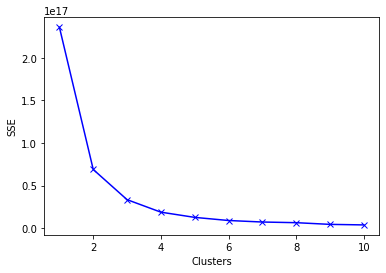

In [63]:
# Elbow method to determine optimum number of clusters
wcss = []
for i in range(1,11):
    k_means = KMeans(n_clusters=i, init='random', random_state=18)
    k_means.fit(df_km)
    wcss.append(k_means.inertia_)

# Plot Elbow curve
plt.plot(np.arange(1,11), wcss, 'bx-')
plt.xlabel('Clusters')
plt.ylabel('SSE')
plt.show()

In [64]:
# Confirming the elbow point
from kneed import KneeLocator
kl = KneeLocator(range(1, 11), wcss, curve="convex", direction="decreasing")
kl.elbow

3

#### 4. Do you get different results with different (random) initialization of centers? Can you find parameters, i.e. k and attributes, that yield "stable" clustering?

We rerun the k-means with differen random seed. From the results, We can see that a random seed of 25 is the most optimal as it minimises WCSS.

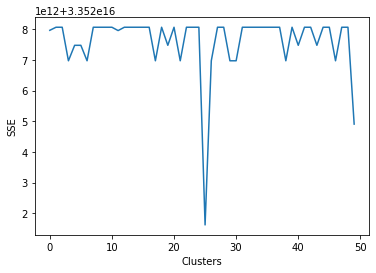

In [65]:
# We can check the results across different random seeds
wcss = []
mini = 9e16
min_i = -1
for i in range(0,50):
    k_means = KMeans(n_clusters=3, init='random', random_state=i)
    k_means.fit(df_km)
    if k_means.inertia_ < mini:
        mini = k_means.inertia_
        min_i = i
    wcss.append(k_means.inertia_)

# Plot curve
plt.plot(np.arange(0,50), wcss)
plt.xlabel('Clusters')
plt.ylabel('SSE')
plt.show()

In [66]:
print("Best random_state = ", min_i)

Best random_state =  25


#### 5. How do you interpret the clusters to your boss? What do each cluster mean (in terms of the attributes)?

We can say that the clusters have the following types of players based on the centroid information obtained:
- Cluster 0: The cluster represents the middle tier of players with a substantial amount of experience, with a middle salary tier and some experience in games (basically the leftovers from the other clusters)
- Cluster 1: The cluster represents players who are at the top of the salary scale with a large number of points and have started many games in their respective seasons
- Cluster 2: The cluster represents players who are likely to be rookies, with minimal experience, low salary, and a relatively low contribution to games played and even points earned

In [67]:
# Analyse the centroids of each cluster:
cen_list = []
labels = df_km.columns
for cen in centroids:
    row = {}
    for i in range(len(labels)-1):
        row[labels[i]] = cen[i]
    cen_list.append(row)

df_centroid = pd.DataFrame(cen_list)
df_centroid

,gs,mp,orb,drb,ast,stl,blk,tov,pf,pts,salary,exp_from_debut
0,41.885317,1654.304083,72.653345,232.333623,172.811468,52.806255,33.811468,98.279757,126.321460,759.772372,1.121626e+07,7.238923
1,16.601991,940.757407,41.320544,120.781447,78.446576,29.471102,18.819573,50.038854,83.689169,369.544196,2.237614e+06,3.747207
2,54.653495,1876.270517,82.762918,314.920973,242.106383,60.303951,42.914894,133.516717,132.039514,1115.632219,2.466266e+07,8.534954


### Linear Regression: What factors predict a player's salary in the most current season?

1. Using salary as the dependent variable, what variables do you include as the independent variables?
2. Why do you choose the model you specified? Do you have any "theory" or rely on your observations?

Independent variables:
- `gs`: The number of games started by the player in the season
- `mp`: The minutes player per game in the season
- `drb`: The number of defensive rebounds per game in the season
- `ast`: The number of assists per game for the player in the season
- `stl`: The number of steals per game for the player in the season
- `tov`: The number of turnovers per game for the player in the season
- `pf`: The number of personal fouls per game for the player in the season
- `pts`: The number of points per game for the player in the season
- `exp_from_debut`: The number of years of experience since the debut for the season

The choice of variables are dependent on the observations in the correlation matrix from the previous section where we went with a threshold of 0.28

In [69]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

feature_cols = ['gs', 'mp', 'drb', 'ast', 'stl', 'tov', 'pf', 'pts', 'exp_from_debut']
X = df_km[feature_cols]
y = df_km.salary

X = sm.add_constant(X)
model = sm.OLS(y,X)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 salary   R-squared:                       0.489
Model:                            OLS   Adj. R-squared:                  0.489
Method:                 Least Squares   F-statistic:                     595.3
Date:                Sun, 06 Mar 2022   Prob (F-statistic):               0.00
Time:                        19:13:07   Log-Likelihood:                -93869.
No. Observations:                5598   AIC:                         1.878e+05
Df Residuals:                    5588   BIC:                         1.878e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const           1.029e+06   1.31e+05      7.856      0.000    7.73e+05    1.29e+06
gs              5.326e+04   4334.982     12.286      0.000    4.48e+04    6.18e+04
mp             -5075.8133    318.884    -15.917      0.000   -5700.951   -4450.676
drb             1.568e+04    937.252     16.730      0.000    1.38e+04    1.75e+04
ast             1.392e+04   1234.415     11.275      0.000    1.15e+04    1.63e+04
stl            -4913.3559   4207.439     -1.168      0.243   -1.32e+04    3334.860
tov             -2.52e+04   3786.177     -6.655      0.000   -3.26e+04   -1.78e+04
pf             -8842.1660   2410.316     -3.668      0.000   -1.36e+04   -4117.011
pts             1.072e+04    447.057     23.973      0.000    9840.773    1.16e+04
exp_from_debut  4.902e+05   1.52e+04     32.338      0.000    4.61e+05     5.2e+05
==============================================================================
Omnibus:                     1651.946   Durbin-Watson:                   1.064
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             7130.499
Skew:                           1.383   Prob(JB):                         0.00
Kurtosis:                       7.787   Cond. No.                     3.35e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.35e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

**SVM feature selection:** <br>
We notice the error messages that the regression suffers from a strong case of multi-collinearity likely due to the large number of features selected. Hence, we will do a feature selecton through the use of a Support Vector Machine with a linear kernel to produce a better model for analysis.

In [70]:
from sklearn.feature_selection import RFE
from sklearn.svm import SVR

#selector = RFE(estimator, n_features_to_select=len(columns), step=1)
columns = ['gs', 'mp', 'drb', 'ast', 'stl', 'tov', 'pf', 'pts', 'exp_from_debut']
for i in range(len(columns)-1, 1, -1):
    estimator = SVR(kernel="linear")
    selector = RFE(estimator, n_features_to_select=i, step=1)
    selector = selector.fit(df_km[columns], df_km['salary'])
    columns = np.array(columns)[selector.support_]
    
    X = sm.add_constant(df_km[columns])
    lm_test = sm.OLS(df_km['salary'], X).fit()
    if lm_test.condition_number < 1000:
        print("Condition number =", lm_test.condition_number, "with", columns)
        print("R-Squared value =", lm_test.rsquared)
        print("AIC =", lm_test.aic)
        print("BIC =", lm_test.bic)
        print()
        
print("End of loop")

Condition number = 490.5986737062729 with ['gs' 'drb' 'pf' 'exp_from_debut']
R-Squared value = 0.3988450820536722
AIC = 188663.82012389222
BIC = 188696.9709472426

Condition number = 378.2757024977643 with ['gs' 'drb' 'exp_from_debut']
R-Squared value = 0.37721981957980466
AIC = 188859.65874980533
BIC = 188886.17940848562

Condition number = 315.6299231918626 with ['gs' 'drb']
R-Squared value = 0.2645007541892358
AIC = 189788.91906973772
BIC = 189808.80956374796

End of loop


By the AIC value and the R-Squared values obtained above, we choose to go with the result with the features `gs`, `drb`, `pf` and `exp_from_debut`.

In [71]:
columns = ['gs', 'drb','pf', 'exp_from_debut']

X = df_km[columns]
y = df_km.salary

X = sm.add_constant(X)
model = sm.OLS(y,X)
lm = model.fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 salary   R-squared:                       0.399
Model:                            OLS   Adj. R-squared:                  0.398
Method:                 Least Squares   F-statistic:                     927.7
Date:                Sun, 06 Mar 2022   Prob (F-statistic):               0.00
Time:                        19:14:24   Log-Likelihood:                -94327.
No. Observations:                5598   AIC:                         1.887e+05
Df Residuals:                    5593   BIC:                         1.887e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const           7.739e+05   1.38e+05      5.599      0.000    5.03e+05    1.04e+06
gs               7.86e+04   3856.702     20.379      0.000     7.1e+04    8.62e+04
drb             1.847e+04    929.666     19.872      0.000    1.67e+04    2.03e+04
pf              -2.65e+04   1867.974    -14.184      0.000   -3.02e+04   -2.28e+04
exp_from_debut  5.051e+05   1.63e+04     31.052      0.000    4.73e+05    5.37e+05
==============================================================================
Omnibus:                     1967.899   Durbin-Watson:                   0.953
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             9350.660
Skew:                           1.640   Prob(JB):                         0.00
Kurtosis:                       8.416   Cond. No.                         491.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [72]:
lm.params

const             773949.591339
gs                 78597.200761
drb                18474.208990
pf                -26496.026882
exp_from_debut    505126.751165
dtype: float64

#### 3. How do you interpret the results, particularly your key variable of interest?

Interpretation of results:
- `const`: The baseline average salary of a player is $ \$ 773949.59 $ when there is no gameplay statistics or experience factor to be considered.
- `gs`: Starting 1 more game increases the salary of the player by $ \$78597.20 $ on average.
- `drb`: Making 1 more defensive rebound on average per game increases the salary of the player by $ \$18474.20 $ on average.
- `pf`: Making 1 more personal foul on average per game decreases the salary of the player by $ \$26496.02 $ on average.
- `exp_from_debut`: Having 1 more year of experience at the point of the season since the debut increases the salary of the player by $ \$505126.75 $ on average.

#### 4. Which predictors are statistically significant?

Based on the results, all predictors are statistically significant 
- `gs`: The number of games started by the player in the season
- `drb`: The number of defensive rebounds per game in the season
- `pf`: The number of personal fouls per game for the player in the season
- `exp_from_debut`: The number of years of experience since the debut for the season

#### 5. If you are the team coach, what do you tell players from your analysis? For instance, each field goal contributes to your salary $ \$X $ amount, so everyone should shoot as often? How does does your analysis contribute to the team’s overall revenue model?

From the analysis, I would tell my players the following:
- Those deployed to start any game are valuable and important in setting the pace of the game 
- Ensure to watch out for and catch any defensive rebounds upon an offensive by the opponent
- Ensure there are minimal personal fouls committed and display good sportsmanship
- Experience in the court matters. 

The analysis will ensure that the revenue model does take into account the player's individual performance both on the defensive play of the game based on the pointers mentioned above. It also accounts for the experience factor where more experienced players should be paid more due to their experience.

#### 6. Do you believe the results?

The following test shows that there is a very large RMSE error involved and hence, it will imply that the model is inaccurate for prediction. We also note that the linear model created also explains only roughly 40% (from R-square value) of the variance of the salary, which means that the model will need to be adjusted so that it will better explain the salary of the NBA players.

In [73]:
from statsmodels.tools.eval_measures import rmse
y = df_km['salary']
y_pred = lm.predict(X)
err = rmse(y, y_pred)
print("RMSE value =", err)
print("Percentage error =", err / np.mean(y))

RMSE value = 5031206.858224803
Percentage error = 0.9314207518854588


### Model Justification: Is the model valid?


#### 3. Do you worry about multicollinearity among your predictors? How can you quickly tell direction/strength of correlations among your variables? (Note that the model will be corrected for multicollinearity first before checking for heteroskedasticity, Q1 and Q2 are answered after)

Yes, there is a high risk of multi-collinearity in the predictors. For example, the number of personal fouls could be correlated to the number of steals as a steal is a gamble such that a personal foul may be commited in the process. 

To study the correlations among the variables, we can use the VIF function to analyse how each variable may be correlated to ALL other variables in the model.

In [74]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif_data = pd.DataFrame()
vif_data["feature"] = X.columns

vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]

vif_data

,feature,VIF
0,const,4.221813
1,gs,2.542799
2,drb,3.752880
3,pf,3.445006
4,exp_from_debut,1.032717


4. If there is strong evidence for multicollinearity, which method do you choose to alleviate it and why

There is strong evidence for multicollinearity based on the VIF function, we will drop the features one by one by the hoghest VIF value until a reasonable VIF value is obtained.

We shall check what happens if they are dropped.

In [75]:
vif_data = pd.DataFrame()
x_mc = df_km.copy()[['gs', 'pf','exp_from_debut']]
vif_data["feature"] = x_mc.columns

vif_data["VIF"] = [variance_inflation_factor(x_mc.values, i) for i in range(len(x_mc.columns))]

vif_data

,feature,VIF
0,gs,3.652797
1,pf,4.274356
2,exp_from_debut,1.714693


In [76]:
vif_data = pd.DataFrame()
x_mc = df_km.copy()[['gs', 'exp_from_debut']]
vif_data["feature"] = x_mc.columns

vif_data["VIF"] = [variance_inflation_factor(x_mc.values, i) for i in range(len(x_mc.columns))]

vif_data

,feature,VIF
0,gs,1.463748
1,exp_from_debut,1.463748


In [78]:
X2 = df_km[['gs', 'exp_from_debut']]
y2 = df_km.salary

X2 = sm.add_constant(X2)
model = sm.OLS(y2,X2)
lm2 = model.fit()
lm2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 salary   R-squared:                       0.356
Model:                            OLS   Adj. R-squared:                  0.356
Method:                 Least Squares   F-statistic:                     1545.
Date:                Sun, 06 Mar 2022   Prob (F-statistic):               0.00
Time:                        19:16:33   Log-Likelihood:                -94521.
No. Observations:                5598   AIC:                         1.890e+05
Df Residuals:                    5595   BIC:                         1.891e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const           4.044e+05   1.16e+05      3.487      0.000    1.77e+05    6.32e+05
gs              1.017e+05   2530.517     40.183      0.000    9.67e+04    1.07e+05
exp_from_debut  5.379e+05   1.67e+04     32.116      0.000    5.05e+05    5.71e+05
==============================================================================
Omnibus:                     1996.746   Durbin-Watson:                   0.916
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             9103.254
Skew:                           1.683   Prob(JB):                         0.00
Kurtosis:                       8.262   Cond. No.                         61.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### 1. Do you think your coefficients in regression are fair, overestimated or underestimated? (hint: check the conditional mean-zero error assumption from the residual plot and what is the implication of the residual average shown in the plot?)

While the residual mean is zero, the plot shows that there is some sort of fan-like pattern in the plot, implying there is some sort of pattern for the residuals going one. This is an indication of heteroskedasticity which will be addressed in the next part. It is likely that the regression coefficients are overestimated. 

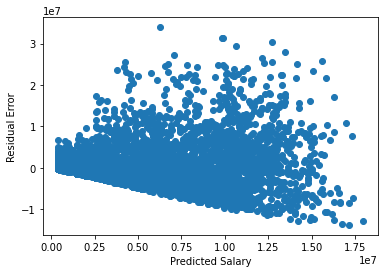

In [79]:
y_pred = lm2.predict(X2)
resid = y - y_pred

plt.xlabel('Predicted Salary')
plt.ylabel('Residual Error')
plt.scatter(y_pred, resid)
plt.show()

In [81]:
print("Residual Average =", np.average(resid))
print("RMSE =", rmse(y, y_pred))

Residual Average = 1.9165480635173834e-10
RMSE = 5208418.018246546


#### 2. Do you worry about heteroskedasticity? How can you detect and fix it if any?

Yes, from the residual plot in the previous question, it is clear that there is a heteroskedasticity issue.

As we see above from the Breusch-Pagan Test, the p-value is small and hence, there is indeed heteroskedastcity present. To fix it, first, we shall analyse if log 10 transformation on the salary does make the model better. At the same time, we will also include White's heteroskedasticity robust standard errors.

In [82]:
from statsmodels.stats.diagnostic import het_breuschpagan

test = het_breuschpagan(lm2.resid,  lm2.model.exog)
labels = ['Test Statistic', 'Test Statistic p-value', 'F-Statistic', 'F-Test p-value']
dict(zip(labels, test))

{'Test Statistic': 626.2769457366979,
 'Test Statistic p-value': 1.0131859568371452e-136,
 'F-Statistic': 352.39488132711784,
 'F-Test p-value': 7.179786086733676e-145}

**Log transformation:** <br>
We see above that the AIC and BIC values are lower, implying a better model was created than the previous and the RMSE value is significantly lower with this model, implying this model is indeed a better model for salary prediction. However, we also note that the R-squared value improved but is still low as well, implying that there may be a better model to explain the salary. 

In [83]:
lm_white = smf.ols(formula='np.log10(salary) ~ gs + exp_from_debut', data = df_km).fit(cov_type='HC3')
lm_white.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       np.log10(salary)   R-squared:                       0.379
Model:                            OLS   Adj. R-squared:                  0.379
Method:                 Least Squares   F-statistic:                     1955.
Date:                Sun, 06 Mar 2022   Prob (F-statistic):               0.00
Time:                        19:17:00   Log-Likelihood:                -3792.7
No. Observations:                5598   AIC:                             7591.
Df Residuals:                    5595   BIC:                             7611.
Df Model:                           2                                         
Covariance Type:                  HC3                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          5.9356      0.011    522.666      0.000       5.913       5.958
gs                 0.0101      0.000     47.451      0.000       0.010       0.010
exp_from_debut     0.0494      0.002     30.231      0.000       0.046       0.053
==============================================================================
Omnibus:                      655.352   Durbin-Watson:                   1.259
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1037.130
Skew:                          -0.833   Prob(JB):                    6.17e-226
Kurtosis:                       4.293   Cond. No.                         61.8
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC3)
"""

In [84]:
test = het_breuschpagan(lm_white.resid,  lm_white.model.exog)
labels = ['Test Statistic', 'Test Statistic p-value', 'F-Statistic', 'F-Test p-value']
dict(zip(labels, test))

{'Test Statistic': 241.35167887447162,
 'Test Statistic p-value': 3.9007564327690136e-53,
 'F-Statistic': 126.04548239401069,
 'F-Test p-value': 2.8610332294338953e-54}

In [85]:
x = df_km[['gs', 'exp_from_debut']]
y = df_km['salary']
y_pred = lm_white.predict(x)
err = rmse(np.log10(y), y_pred)
print("RMSE value =", err)
print("Percentage error =", err / np.mean(np.log10(y)))

RMSE value = 0.4764308496420446
Percentage error = 0.0743034097980108


### Panel Analysis: What predicts the players' salaries?


#### 1. Which time-varying variables matter to explain player’s salary?

The only time-varying variable will include the `exp_from_debut`

#### 2. Which are time-invariant predictors in your data set? Do you worry about any fixed effect $\alpha_i$ that might correlated with your predictors? If yes, provide examples of such fixed effects.

Time-invariant predictors: `gs`. The fixed-effect will very likely be uncorrelated to the predictors.

#### 3. Which model of panel analysis do you choose, "fixed-effect" or random effect models and why?

A random-effect model should be used as there should be no correlation between the fixed effect and all covariates for all periods.

To verify this, both the Fixed-Effect model and the Random-Effect models are built and the Panel Hausman Test is conducted (null hypothesis is that we use the Random-Effects model). We have insufficient evidence to reject the null hypothesis and hence, the Random-Effect model should be used.

In [87]:
from linearmodels.panel import PanelOLS
data_with_season['year'] = (data_with_season['season'].str[:4]).astype(int)
df_panel = data_with_season[['year', 'code', 'gs', 'drb','pf', 'exp_from_debut','salary']]

year = pd.Categorical(df_panel.year)
df_panel = df_panel.set_index(['code', 'year'])
df_panel['year'] = year

X = sm.add_constant(df_panel[['gs', 'exp_from_debut', 'year']])
panelModel = PanelOLS(np.log10(df_panel['salary']), X).fit()

panelModel

<ipython-input-87-09da08bf6c43>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_with_season['year'] = (data_with_season['season'].str[:4]).astype(int)


Dep. Variable:,salary,R-squared:,0.4021
Estimator:,PanelOLS,R-squared (Between):,0.4254
No. Observations:,5598,R-squared (Within):,0.0827
Date:,"Sun, Mar 06 2022",R-squared (Overall):,0.4021
Time:,19:17:34,Log-likelihood,-3685.8
Cov. Estimator:,Unadjusted,,
,,F-statistic:,288.86
Entities:,1292,P-value,0.0000
Avg Obs:,4.3328,Distribution:,"F(13,5584)"
Min Obs:,1.0000,,
Max Obs:,14.000,F-statistic (robust):,288.86


In [88]:
from linearmodels.panel import RandomEffects
randomModel = RandomEffects(np.log10(df_panel['salary']), X).fit()

randomModel

Dep. Variable:,salary,R-squared:,0.7243
Estimator:,RandomEffects,R-squared (Between):,0.3938
No. Observations:,5598,R-squared (Within):,0.1469
Date:,"Sun, Mar 06 2022",R-squared (Overall):,0.3586
Time:,19:17:46,Log-likelihood,-2499.1
Cov. Estimator:,Unadjusted,,
,,F-statistic:,1128.6
Entities:,1292,P-value,0.0000
Avg Obs:,4.3328,Distribution:,"F(13,5584)"
Min Obs:,1.0000,,
Max Obs:,14.000,F-statistic (robust):,136.40


In [89]:
from scipy import stats
# Hausman test for fixed versus random effects modeL
psi = panelModel.cov - randomModel.cov
diff = panelModel.params - randomModel.params
W = diff.dot(np.linalg.inv(psi)).dot(diff)
dof = randomModel.params.size -1
pvalue = stats.chi2(dof).sf(W)

print("Hausman Test: chisq = {0}, df = {1}, p-value = {2}".format(W, dof, pvalue))

Hausman Test: chisq = -788.8409313127048, df = 13, p-value = 1.0


#### 4. Based on your results, what do you recommend to the team owner? How much should team pay existing players?

I will recommend to the team owner, in the given current season, that they should pay, based on the player's past pay records on average, his total years of experience as of the current season, as well as the number of games started by the player in the season.

### Interpretation: How to make sense of the results?

Describe the analysis and you are not required to execute the analysis (if you wish, you can).

#### 1. Do you think your result could be interpreted in a causal relationship? Why or why not?

No. To make causal inferences, we will need to resolve he endogeneity issue which is currently present in the analysis of the prevous section, which will require more work and other tools than what we currently have.

#### 2. Winning a game is a team effort, but solely that of a single player. If the objective is to win, how can your prediction include cooperation amongst members?

The variables can include teamwork-based observations such as assists which if, assuming positively correlated to winning, can imply that helping each other out as a team may lead to an increase in points on average. Variables which reflect totals (such as total blocks, total defensive rebounds or numbers obtained from a groupby then sum) rather than individualistic statistic can also be included as independent variables to explain how a team may win a game on average.

#### 3. New athletes are drafted using a system where teams are randomly set an order (eg. 1st for LA Lakers, 2nd for Chicago Bulls, and so on), and get to place a contract with the player in that order. Players then can choose to accept or reject the offer. Which variables do you think matter for a successful draft for the player? Describe what kind of data you need to answer such question and how?

New players will want to know the following to accept / reject:
- The given team's win / loss record
- The given team's offensive and defensive rankings over the seasons
- The number of times the given team was champion
- The positions available in the team for the player to play in, which may require data from existing players on whether or not contracts are up
- The coach data of the team's current coach, where variables such as the number of times the coach led the team to a top position or championship and loyalty of the coach to the team

Data can be obtained from the same website source whereby player data, team data and coach data can be scraped. For the player data, the data to obtain will be the draft data such as the draft team and the draft rank. For the team data, team statistics from each and every season will be required as some variables can be used to explain if a player was more enticed to accept / reject a draft, and some coach data such as the years of experience and how many times he has lead teams to winning may be important. 

Relevant variables will be pulled into a logit regression with the accept / reject as an independent variable and the prediction to accept / reject will be based on a certain probabilty threshold.